# ENSEMBLE LEARNING BUSINESS CASE STUDY

## Problem Statement:
### As the company gets bigger, the high churn becomes a bigger problem. To find new drivers, a ride sharing company is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.
### We are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

* Demographics (city, age, gender etc.)
* Tenure information (joining date, Last Date)
* Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

### Structure of Notebook:
1. Exploratory Data Analysis:  
>* Understanding the data identifying shape and data types 
>* Feature Engineering
>* Data condenstation to make each row represent one driver's data
>* Missing value treatment along with Univariate and Bivariate analysis
2. Data Preprocessing: KNN Imputation, Class Imbalance Treatment, Encoding, Standardization
3. Model Building: Bagging and Boosting Algorithm Models
4. Results Evaluation: Classification Report and ROC AUC Curve
5. Actionable Insights and Business Recommendations



In [268]:
#importing relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, f_oneway
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (classification_report, roc_auc_score,roc_curve, auc,
                             accuracy_score,precision_score, recall_score, f1_score,
                            confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)

## 1. Exploratory Data Analysis

In [3]:
#reading data from csv file

df = pd.read_csv(r"C:\KT Personal\Data Science\Scaler\Projects\Ensemble Learning\driver_scaler.txt")

In [4]:
df.shape

(19104, 14)

>- Dataset has 19104 data points and 14 features 

In [5]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


### Column Profiling:

1. MMMM-YY : Reporting Date (Monthly)
2. Driver_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [6]:
df.sample(10)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
1623,1623,12/01/20,245,38.0,0.0,C23,2,77903,09/11/20,15/12/20,2,2,0,1
4568,4568,07/01/20,682,29.0,0.0,C14,1,40008,19/07/19,NaN,1,1,779190,2
15017,15017,04/01/19,2224,47.0,1.0,C27,2,61291,27/08/18,NaN,1,1,139830,3
16668,16668,05/01/20,2471,27.0,0.0,C24,0,55344,04/06/20,NaN,2,2,0,1
2892,2892,12/01/19,434,29.0,1.0,C6,2,80469,08/11/17,NaN,1,2,710000,4
14634,14634,01/01/20,2181,35.0,1.0,C24,1,47440,24/11/19,19/01/20,2,2,0,1
10366,10366,11/01/20,1549,36.0,1.0,C21,1,95945,30/08/15,NaN,1,3,970680,3
5477,5477,12/01/19,819,40.0,0.0,C15,1,114358,11/01/13,NaN,2,4,1289680,3
8839,8839,07/01/20,1301,33.0,0.0,C7,1,74620,07/11/19,NaN,2,2,300000,1
8008,8008,12/01/20,1190,28.0,0.0,C1,0,61991,10/04/20,NaN,2,2,0,3


In [7]:
#dropping unnamed: 0 column as it is not required

df.drop('Unnamed: 0', axis = 1, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


>- date of entry, date of joining and last working day can be converted to datetime objects
>- There are null values in some columns
>- Gender, Education level, Joining Designation, Grade and QUarterly rating can be converted to object type as they are categorical variables

In [9]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [10]:
# Converting Gender, Education level, Joining Designation, Grade and QUarterly rating into object data type

df[['Driver_ID','Gender', 'Education_Level', 'Joining Designation', 'Grade', 'Quarterly Rating']] = df[['Driver_ID','Gender', 'Education_Level', 'Joining Designation', 'Grade', 'Quarterly Rating']].astype('object')

In [11]:
# converting date of entry, date of joining and last working day to datetime

df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [12]:
# Statistical summary

df.describe()

,Age,Income,Total Business Value
count,19043.000000,19104.000000,1.910400e+04
mean,34.668435,65652.025126,5.716621e+05
std,6.257912,30914.515344,1.128312e+06
min,21.000000,10747.000000,-6.000000e+06
25%,30.000000,42383.000000,0.000000e+00
50%,34.000000,60087.000000,2.500000e+05
75%,39.000000,83969.000000,6.997000e+05
max,58.000000,188418.000000,3.374772e+07


### Insights:
>- Age has similar mean and median values showing no signs of oultiers
>- Income has difference of 5000 between mean and median values hinting at presence of outliers
>- Total Business values also seems to have presence of outliers

In [13]:
# Summary of categorical variables

df.describe(include = 'object').T

,count,unique,top,freq
Driver_ID,19104,2381,2110,24
Gender,19052.0,2.0,0.0,11074.0
City,19104,29,C20,1008
Education_Level,19104,3,1,6864
Joining Designation,19104,5,1,9831
Grade,19104,5,2,6627
Quarterly Rating,19104,4,1,7679


### Insights:
>- **2381 unique driver ids present which means dataset contains info on 2381 drivers.**
>- Data cover 29 cities

In [14]:
# checking the range of dates for which data is available

first_date = df['MMM-YY'].dt.date.min()
last_date = df['MMM-YY'].dt.date.max()

print(f'Data is present for dates {first_date} to {last_date}')

Data is present for dates 2019-01-01 to 2020-12-01


>- Therefore data is present for 2 years almost from January 2019 to December 2020

In [15]:
# Checking for missing values

df.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

### Insights:
>- We will use the missing values in Last working day column to create feature called churn and find the whether drivers are still working or quit the company
>- **Missing values in Age and Gender columns may be imputed using KNN Imputer**

In [16]:
# Using KNN Imputer to replace missing values in Age and Gender columns
missing_cols = ['Age', 'Gender']
imputer = KNNImputer(n_neighbors=5)
df[missing_cols] = pd.DataFrame(imputer.fit_transform(df[missing_cols]),columns = missing_cols)

In [17]:
df.isna().sum()

# no missing values in columns except for Last Working day

MMM-YY                      0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [18]:
#checking unique values in age and gender after KNN Imputation
# as it imputes with mean of k neighbors, the value can be float which needs to be converted to int

df['Age'].unique()

array([28. , 31. , 43. , 29. , 34. , 35. , 30. , 39. , 42. , 27. , 26. ,
       33. , 40. , 30.2, 41. , 32. , 22. , 44. , 36. , 21. , 49. , 37. ,
       38. , 46. , 47. , 48. , 25. , 24. , 45. , 51. , 52. , 23. , 50. ,
       53. , 54. , 55. , 58. ])

>- It contains a value 30.2 which can be rounded off to 30

In [19]:
#rounding off values in Age column

df['Age'] = np.round(df['Age'])

In [20]:
df['Gender'].unique()

array([0. , 1. , 0.2, 0.8, 0.6])

>- Gender can be only 0 and 1. Therefore 0.2 can be rounded off to 0 and 0.6 and 0.8 can be rounded to 1

In [21]:
# rounding off values in Gender column

df['Gender'] = np.round(df['Gender'])

In [22]:
df['Gender'] = df['Gender'].astype('object')

### Outlier Treatment

In [23]:
numerical_data = df.select_dtypes(include = 'number')
num_cols = numerical_data.columns

In [24]:
num_cols

Index(['Age', 'Income', 'Total Business Value'], dtype='object')

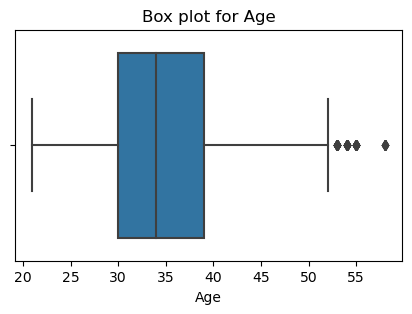

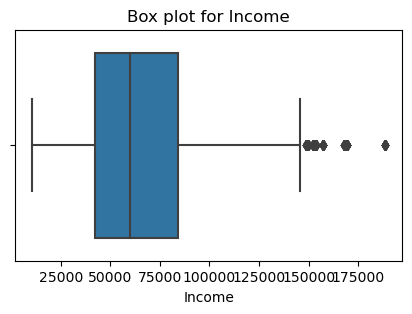

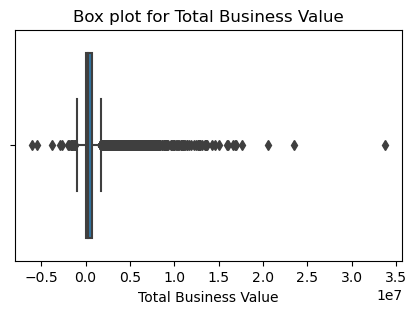

In [25]:
# Checking for outliers with box plot for numerical variables

def box_plot(col):
    plt.figure(figsize = [5,3])
    sns.boxplot(x = df[col])
    plt.title(f'Box plot for {col}')
    plt.show()

for col in num_cols:
    box_plot(col)

### Insights:
>- All the three numerical variables have outliers 
>- Outliers may be removed with Z-score method by removing observations above 3rd Standard Deviation

In [26]:
#removal of outliers in numerical columns above 3 Std dev values

for col in num_cols:
    mean = df[col].mean()
    std = df[col].std()
    
    upper_limit = mean + 3*std
    lower_limit = mean - 3*std
    
    df = df.loc[(df[col]>lower_limit) & (df[col]<upper_limit)]

In [27]:
# checking for remaining outliers in numerical columns
ol = []
for col in num_cols:
    mean = df[col].mean()
    std = df[col].std()
    
    upper_limit = mean + 2*std
    lower_limit = mean - 2*std
    
    outliers = df.loc[(df[col]<lower_limit) & (df[col]>upper_limit)]
    perc = np.round((outliers.shape[0]/df.shape[0]*100),2)
    ol.append(perc)
pd.DataFrame(ol, index= num_cols, columns= ['Perc of Outliers by Std Dev method'])

,Perc of Outliers by Std Dev method
Age,0.0
Income,0.0
Total Business Value,0.0


### Feature Engineering
We will create 2 features out of data in present shape before we condense the data:
>- **quarterly_rating_trend**- it will be a binary variable with value 1 when there is increase in quarterly rating and 0 otherwise
>- **monthly income trend**- it will be a binary variable with value 1 when there is increase in monthly income and 0 otherwise  

**Third feature Churn will be created once data is condensed.**

In [28]:
# creating quarterly_rating_trend based on quarterly rating change for each driver

df['first_rating'] = df.groupby('Driver_ID')['Quarterly Rating'].transform('first')
df['last_rating'] = df.groupby('Driver_ID')['Quarterly Rating'].transform('last')
df['quarterly_rating_trend'] = df.apply(lambda row: 1 if row.last_rating>row.first_rating else 0, axis=1)

In [29]:
# creating monthly_income_trend based on quarterly rating change for each driver

df['first_rating'] = df.groupby('Driver_ID')['Income'].transform('first')
df['last_rating'] = df.groupby('Driver_ID')['Income'].transform('last')
df['monthly_income_trend'] = df.apply(lambda row: 1 if row.last_rating>row.first_rating else 0, axis=1)

In [30]:
#dropping first_rating and last_rating

df.drop(['first_rating', 'last_rating'], axis =1, inplace = True)

### Condensing the data so that each row represents information on one driver

In [31]:
# creating dictionary to aggredate columns by Driver_ID by choosing aggregation functions for each variable

cols = ['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating',
       'quarterly_rating_trend', 'monthly_income_trend']
temp = ['last', 'last', 'last', 'last', 'last', 'last', 'last', 'last', 'last', 'first', 'last', 'sum', 'last', 'last', 'last']
agg = dict(zip(cols, temp))
agg

{'MMM-YY': 'last',
 'Driver_ID': 'last',
 'Age': 'last',
 'Gender': 'last',
 'City': 'last',
 'Education_Level': 'last',
 'Income': 'last',
 'Dateofjoining': 'last',
 'LastWorkingDate': 'last',
 'Joining Designation': 'first',
 'Grade': 'last',
 'Total Business Value': 'sum',
 'Quarterly Rating': 'last',
 'quarterly_rating_trend': 'last',
 'monthly_income_trend': 'last'}

In [32]:
# aggregating the data based on Driver_ID

df = df.groupby('Driver_ID').agg(agg)
df.head(10)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,quarterly_rating_trend,monthly_income_trend
Driver_ID,,,,,,,,,,,,,,,
1,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2,0,0
2,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0
4,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,350000,1,0,0
5,2019-03-01,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,120360,1,0,0
6,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,1265000,2,1,0
8,2020-11-01,8,34.0,0.0,C2,0,70656,2020-09-19,2020-11-15,3,3,0,1,0,0
11,2020-12-01,11,28.0,1.0,C19,2,42172,2020-12-07,NaT,1,1,0,1,0,0
12,2019-12-01,12,35.0,0.0,C23,2,28116,2019-06-29,2019-12-21,1,1,2607180,1,0,0
13,2020-11-01,13,31.0,0.0,C19,2,119227,2015-05-28,2020-11-25,1,4,10213040,1,0,0


### Creating target variable Churn based on Last working day. If LWD is null, that means churn = 1, else it means driver left. Therefore churn = 0 in that case

In [33]:
df['Churn'] = df['LastWorkingDate'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [34]:
df = df.reset_index(drop=True)

>- **Dropping Driver_ID** as it does not serve any purpose in model building
>- **Extracting month from Date of joining** and dropping joining date column
>- **Dropping Last working date** as it has served its purpose of finding whether driver is still working or not

In [35]:
# extracting month from date of joining

df['month_of_joining'] = df['Dateofjoining'].dt.month

In [36]:
# dropping 'Driver_ID','MMM-YY', 'Dateofjoining', 'LastWorkingDate'

df.drop(['Driver_ID','MMM-YY', 'Dateofjoining', 'LastWorkingDate'], axis = 1, inplace = True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     2377 non-null   float64
 1   Gender                  2377 non-null   object 
 2   City                    2377 non-null   object 
 3   Education_Level         2377 non-null   object 
 4   Income                  2377 non-null   int64  
 5   Joining Designation     2377 non-null   object 
 6   Grade                   2377 non-null   object 
 7   Total Business Value    2377 non-null   int64  
 8   Quarterly Rating        2377 non-null   object 
 9   quarterly_rating_trend  2377 non-null   int64  
 10  monthly_income_trend    2377 non-null   int64  
 11  Churn                   2377 non-null   int64  
 12  month_of_joining        2377 non-null   int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 241.5+ KB


In [38]:
df['month_of_joining'] = df['month_of_joining'].astype('object')
df['Churn'] = df['Churn'].astype('object')
df['monthly_income_trend'] = df['monthly_income_trend'].astype('object')
df['quarterly_rating_trend'] = df['quarterly_rating_trend'].astype('object')

In [39]:
#statistical summary of condesnsed data

df.describe()

,Age,Income,Total Business Value
count,2377.000000,2377.000000,2.377000e+03
mean,33.655027,59197.639882,3.652054e+06
std,5.933594,28096.937706,6.286966e+06
min,21.000000,10747.000000,-1.385530e+06
25%,29.000000,39104.000000,0.000000e+00
50%,33.000000,55313.000000,8.007100e+05
75%,37.000000,75765.000000,3.981020e+06
max,53.000000,157124.000000,3.910153e+07


>- Total Business value shows signs of outliers as mean and median are far from each other
>- Age and Income have mean and median relative close and do not show sign of outliers

In [40]:
# Summary of categorical data

df.describe(include = 'object').T

,count,unique,top,freq
Gender,2377.0,2.0,0.0,1399.0
City,2377,29,C20,152
Education_Level,2377,3,2,799
Joining Designation,2377,5,1,1025
Grade,2377,5,2,856
Quarterly Rating,2377,4,1,1742
quarterly_rating_trend,2377,2,0,2020
monthly_income_trend,2377,2,0,2335
Churn,2377,2,1,1614
month_of_joining,2377,12,7,295


>- Data is available for 2377 drivers 
>- Month of joining have data from all the 12 months

### Univariate Analysis

In [41]:
# function for univariate analysis of numerical variables and categorical variables

def numerical_uni(col):
    
    plt.figure(figsize=[10,3])
    plt.subplot(1,2,1)
    sns.histplot(x = df[col], kde= True)

    plt.subplot(1,2,2)
    sns.histplot(x = df[col], stat = 'percent', cumulative= True, bins = 20)
    return df[col].describe().to_frame().T

def categorical_uni(col):
    plt.figure(figsize=[5,3])
    sns.countplot(x = col, data = df,order = sorted(df[col].unique()))
    plt.xticks()
    percent = df[col].value_counts(normalize = True, sort= False).to_frame().rename({col:'Percentage'}, axis = 1)
    percent = percent*100
    percent = percent.reset_index().rename({'index':'Category'}, axis = 1)
    percent = percent.sort_values('Category')
    percent.reset_index(drop = True, inplace= True)
    return percent.T

,0,1
Category,0.000000,1.000000
Percentage,32.099285,67.900715


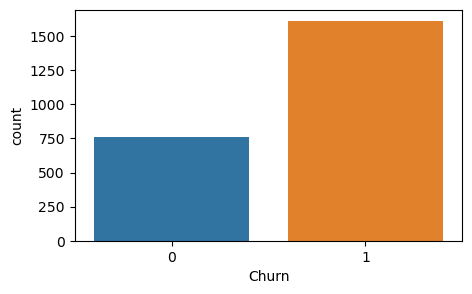

In [42]:
# Analysis of target variable- Churn

categorical_uni('Churn')

### Insights:
>- **Churn is our target variable for the model.**
>- **Churn = 1 represents drivers who quit while Churn = 0 represent drivers who were retained.**
>- **Data is imbalanced. As 68% of drivers are in class 1 and 32% in class 0. Values in class 1 are double to that of class 0.** 

,count,mean,std,min,25%,50%,75%,max
Age,2377.0,33.655027,5.933594,21.0,29.0,33.0,37.0,53.0


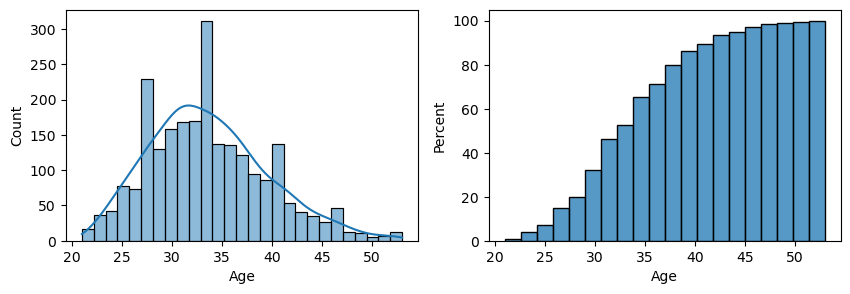

In [43]:
# Age

numerical_uni('Age')
df['Age'].describe().to_frame().T

>- Age of drivers seem to be normally distributed with mean and median age at 33 

,0,1
Category,0.0000,1.0000
Percentage,58.8557,41.1443


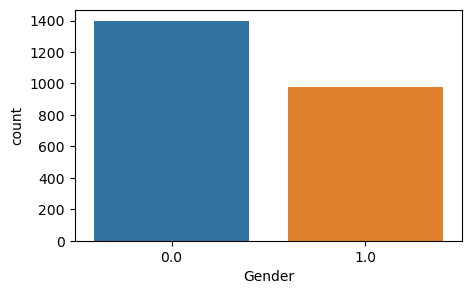

In [44]:
# Gender

categorical_uni('Gender')

>- 0 represents Male while 1 represents Female
>- 58% of the drivers are male while 41% are female. The ratio is almost balanced

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
Category,C20,C15,C29,C26,C8,C27,C10,C16,C22,C3,C28,C12,C1,C14,C21,C5,C6,C4,C7,C9,C25,C23,C24,C19,C2,C17,C13,C18,C11
Percentage,6.394615,4.249053,4.038704,3.912495,3.744215,3.744215,3.618006,3.533866,3.449727,3.449727,3.449727,3.407657,3.365587,3.323517,3.323517,3.281447,3.281447,3.239377,3.155238,3.155238,3.113168,3.113168,3.029028,3.029028,3.029028,2.986958,2.986958,2.902819,2.692469


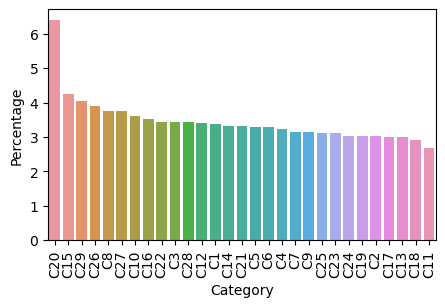

In [45]:
# City

plt.figure(figsize=[5,3])
plt.xticks(rotation = 90)
percent = df['City'].value_counts(normalize = True, sort=True).to_frame().rename({'City':'Percentage'}, axis = 1)
percent = percent*100
percent = percent.reset_index().rename({'index':'Category'}, axis = 1)
percent = percent.sort_values('Percentage', ascending = False)
percent.reset_index(drop = True, inplace= True)
sns.barplot(x = 'Category',y = 'Percentage', data = percent)
percent.T

>- Most drivers belong to city C20 followed by C15 and C29
>- Except for C20, percentage of drivers from each city ranges from 2.7% to 4.2%

,0,1,2
Category,0.000000,1.00000,2.000000
Percentage,32.982751,33.40345,33.613799


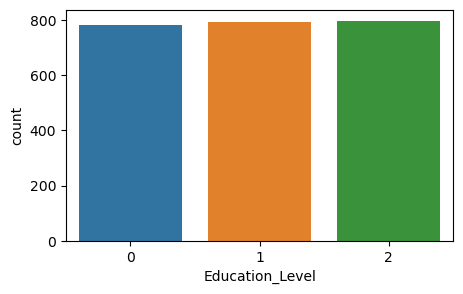

In [46]:
# Education_level

categorical_uni('Education_Level')

>- Drivers from all the 3 education levels present in equal numbers

,count,mean,std,min,25%,50%,75%,max
Income,2377.0,59197.639882,28096.937706,10747.0,39104.0,55313.0,75765.0,157124.0


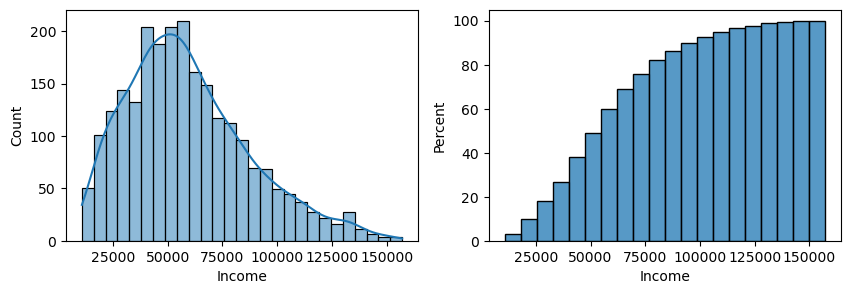

In [47]:
# Income

numerical_uni('Income')

>- There seems to be some presence of outliers as the curve is right skewed.
>- Mean of monthly income is 59000 while median is 55000
>- 50% of total drivers earn between 39000 and 75000. 
>- Lowest income value is 10747 and highest is 157124

,0,1,2,3,4
Category,1.000000,2.000000,3.000000,4.000000,5.000000
Percentage,43.121582,34.202777,20.740429,1.514514,0.420698


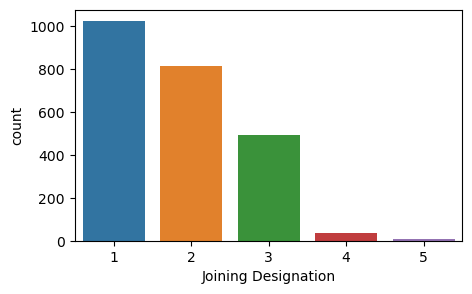

In [48]:
# Joining Designation

categorical_uni('Joining Designation')

>- 43% belong to joining designation of 1 and very minimal (0.4%)belong to designation 5
>- As designation increases, number of drivers in that joining designation decreases

,0,1,2,3,4
Category,1.000000,2.00000,3.000000,4.000000,5.000000
Percentage,31.131679,36.01178,26.167438,5.805637,0.883467


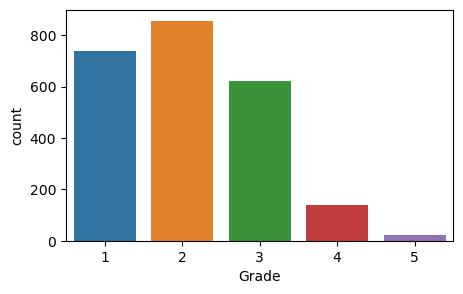

In [49]:
# Grade

categorical_uni('Grade')

>- Most drivers, i.e. 36% belong to grade 2 followed by grade 1 at 31%
>- Grade 5 has the least number of drivers at 0.88%

,count,mean,std,min,25%,50%,75%,max
Total Business Value,2377.0,3.652054e+06,6.286966e+06,-1385530.0,0.0,800710.0,3981020.0,39101530.0


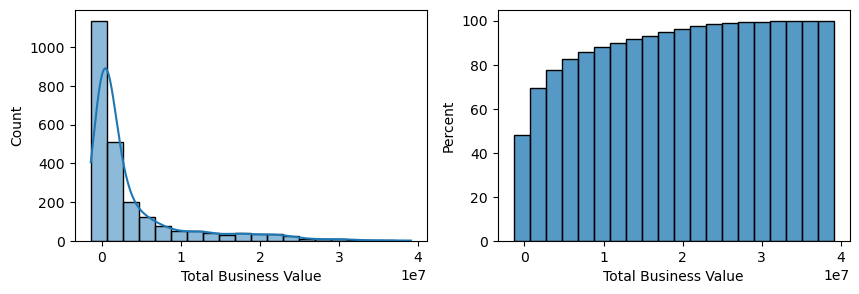

In [50]:
# Total Business Value

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
sns.histplot(x = df['Total Business Value'], kde= True, bins = 20)

plt.subplot(1,2,2)
sns.histplot(x = df['Total Business Value'], stat = 'percent', cumulative= True, bins = 20)
df['Total Business Value'].describe().to_frame().T

>- As many drivers have negative value for total business value due to refund or car emi adjustments, the values show a wide range of -1385530 to +39101530
>- This makes the plot highly skewed.
>- We can inspect the data on drivers with negative and positive values for Total Business Value separately

,count,mean,std,min,25%,50%,75%,max
Total Business Value,731.0,-6028.454172,67584.028734,-1385530.0,0.0,0.0,0.0,0.0


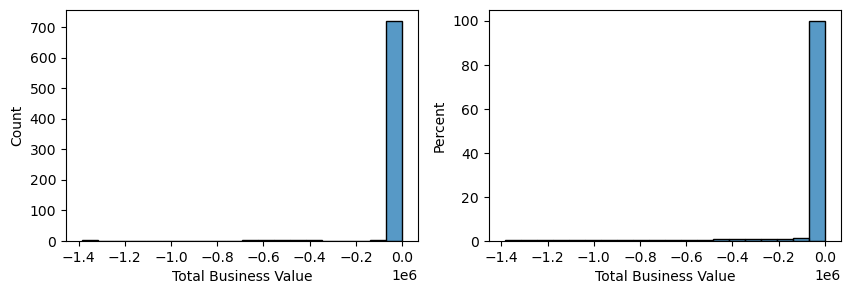

In [51]:
# analysis of negative values in Total Business Value

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
sns.histplot(x = df['Total Business Value'].loc[df['Total Business Value']<=0], bins =20)

plt.subplot(1,2,2)
sns.histplot(x = df['Total Business Value'].loc[df['Total Business Value']<=0], stat = 'percent', cumulative= True, bins = 20)
df['Total Business Value'].loc[df['Total Business Value']<=0].describe().to_frame().T

>- Most negative values are just below 0 between 0 and -10000

,count,mean,std,min,25%,50%,75%,max
Total Business Value,1646.0,5.276634e+06,6.964267e+06,19580.0,651190.0,2199780.0,6704830.0,39101530.0


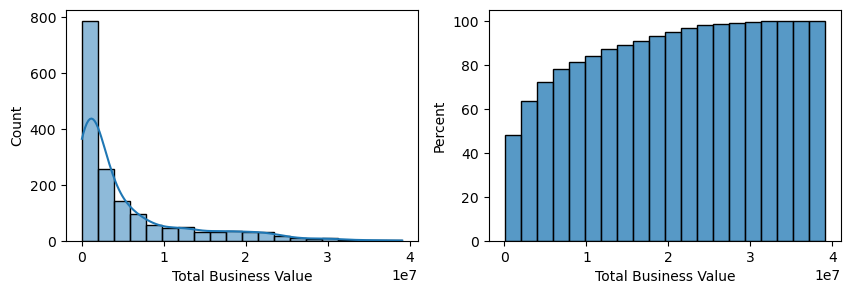

In [52]:
# analysis of positive values in Total Business Value

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
sns.histplot(x = df['Total Business Value'].loc[df['Total Business Value']>0], kde= True, bins = 20)

plt.subplot(1,2,2)
sns.histplot(x = df['Total Business Value'].loc[df['Total Business Value']>0], stat = 'percent', cumulative= True, bins = 20)
df['Total Business Value'].loc[df['Total Business Value']>0].describe().to_frame().T

>- Most positive values of Total Business Value lie between 0 and 6700000 
>- **Therefore most values of Total Business Value range between -10000 to 6700000.**

,0,1,2,3
Category,1.000000,2.000000,3.000000,4.000000
Percentage,73.285654,15.187211,7.109802,4.417333


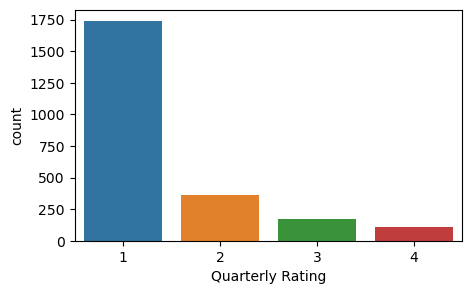

In [53]:
# Quarterly Rating

categorical_uni('Quarterly Rating')

>- Most drivers (73%) received a lower quarterly rating of 1 when the last rating was recorded
>- Very few drivers at 27% combined received the higher rating of 2, 3 and 4
>- No driver received a rating of 5
>- This might reflect on the quality of drivers or the rating process of the organization

,0,1
Category,0.000000,1.000000
Percentage,84.981069,15.018931


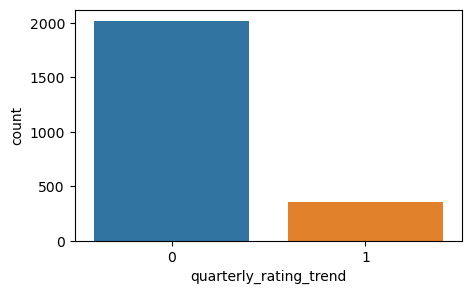

In [54]:
# quarterly_rating_trend

categorical_uni('quarterly_rating_trend')

>- Only 15% of the drivers received a raise in quarterly rating in the 2 years of data present
>- 85% of the drivers did not see any improvement in their quarterly ratings
>- Data is highly imbalanced with respect to this feature.

,0,1
Category,0.000000,1.000000
Percentage,98.233067,1.766933


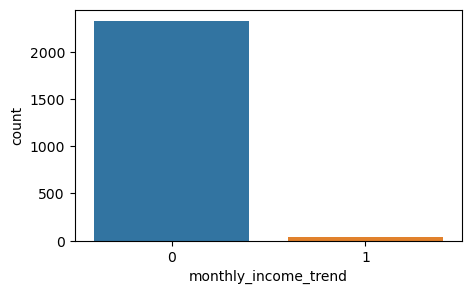

In [55]:
# monthly_income_trend

categorical_uni('monthly_income_trend')

>- **Only 1.8% of the drivers saw a raise in monthly income over 2 years**
>- **98% drivers did not see any growth in monthly income over a period of 2 years.**
>- Data is highly imbalanced with respect to this feature.

,0,1,2,3,4,5,6,7,8,9,10,11
Category,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000
Percentage,6.857383,3.197308,2.397981,4.375263,11.569205,9.676062,12.410602,9.381573,9.339504,11.316786,10.643668,8.834666


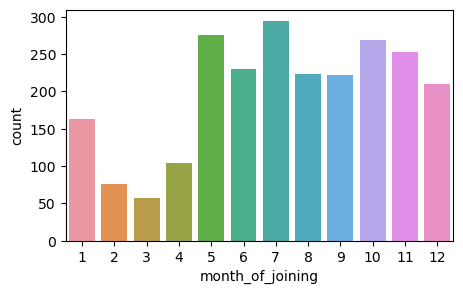

In [56]:
# month_of_joining

categorical_uni('month_of_joining')

>- January to April saw a lower joining number of drivers compared to rest of the months
>- Average number of drivers joining from May to December was 200-250 compared to 50-150 between January to April

### Bivariate Analysis
#### Initially we will be checking relation between all independent variables and target variable.

In [57]:
# Defining functions for bivariate analysis

#for comparing 2 numerical variables

def numerical_biv(x, y):
    plt.figure(figsize=[15,5])
    
    plt.subplot(1,2,1)
    plt.title('Scatter Plot')
    sns.scatterplot(x = x, y= y, data = df)

    plt.subplot(1,2,2)
    plt.title('Line Plot')
    sns.lineplot(x = x, y = y, data = df)
    corr = np.corrcoef(df[x], df[y])[0][1]
    plt.show()
    print("Pearson's Correlation factor: ", corr)

#for comparing 2 categorical variables

def categorical_biv(x,y):
    plt.figure(figsize= [15,5])

    plt.subplot(1,2,1)
    sns.boxplot(x = x, y = y, data = df)

    plt.subplot(1,2,2)
    sns.histplot(x = df[y], hue = df[x], bins = 20)
    
    # ANOVA test to check relationship
#     s = []
#     categories = df[x].unique()
#     for i in categories:
#         s1 = df.loc[df[x]==i][y]
#         s.append(s1)
     
#     test, p_val= f_oneway(*s)
#     print(f'p value for ANOVA test of relation between {x} and {y} is:', p_val)

    # 2-tailed T-Test to check relationship
    sample_size = df.groupby(x)[y].count().min()

    categories = df[x].unique()
    s1 = df.loc[df[x]==categories[0]][y].sample(sample_size)
    s2 = df.loc[df[x]==categories[1]][y].sample(sample_size)
    
    # conducting independent t test using scipy.stats library function
    test_stats, p_val = ttest_ind (s1,s2, equal_var=False)
    print(f'Null Hypothesis: Mean of {y} values for categories {categories[0]} and {categories[1]} is same')
    print(f'Alternate Hypothesis: Mean of values for categories {categories[0]} and {categories[1]} is not same')
    print()
    print('p value for two tailed T test is: ', p_val)
    print()
    if p_val<0.05:
        print(f'Mean of {y} and {x} are different for both categories therefore {y} has some relation with {x}')
    else:
        print(f'Mean of {y} and {x} are same for both categories therefore {y} has minimal or no impact on {x}')
    
    plt.show()
    
    print('INSIGHTS:')
    if np.mean(df.loc[df[x]==categories[0]][y])>np.mean(df.loc[df[x]==categories[1]][y]):
        print(f'Mean of {y} for {categories[0]} at {round(np.mean(df.loc[df[x]==categories[0]][y]),2)} is greater than that for {categories[1]} at {round(np.mean(df.loc[df[x]==categories[1]][y]),2)}')
    else:
        print(f'Mean of {y} for {categories[0]} at {round(np.mean(df.loc[df[x]==categories[0]][y]),2)} is lower than that for {categories[1]} at {round(np.mean(df.loc[df[x]==categories[1]][y]),2)}')
    print()
    if p_val<0.05:
        print(f'{y} and {x}  has some relation has been also seen through hypothesis testing and results shown above')
    else:
        print(f'{y} has minimal or no impact on {x} has been also seen through hypothesis testing and results shown above')
    return df.groupby(x)[y].describe()

# function to convert categorical columns into contingency tables 
# and return p value of chisquared test

def chi_squared(cat1, cat2):
    size_cat1 = df[cat1].nunique()
    size_cat2 = df[cat2].nunique()
    lst = []
    for i in range(size_cat1):
        lst.append(pd.crosstab(df[cat1], df[cat2]).reset_index().iloc[i, 1:size_cat2 + 1].to_list())
    
    from scipy.stats import chi2_contingency
    stat, p, dof, expected = chi2_contingency(lst)
    
    print('Null Hypothesis: Both the variables are independent of each other')
    print()
    print('Alternate Hypothesis: Both the variables are related and dependent on each other')
    print('p value for Chi Square test is:', p)
    print()
    if p<0.05:    
        print(f'It means {cat1} and {cat2} are related and dependent on each other')
    else:
        print(f'It means {cat1} and {cat2} are unrelated and independent of each other')
    return p

def both_categorical(x,y):
    pd.crosstab(df[x], df[y]).plot(kind='bar',figsize = [5,3])
    
    p_val = chi_squared(x, y)
    plt.show()    
    return pd.crosstab(df[x], df[y], margins= True)

Null Hypothesis: Mean of Age values for categories 1 and 0 is same
Alternate Hypothesis: Mean of values for categories 1 and 0 is not same

p value for two tailed T test is:  2.0173855497092415e-05

Mean of Age and Churn are different for both categories therefore Age has some relation with Churn


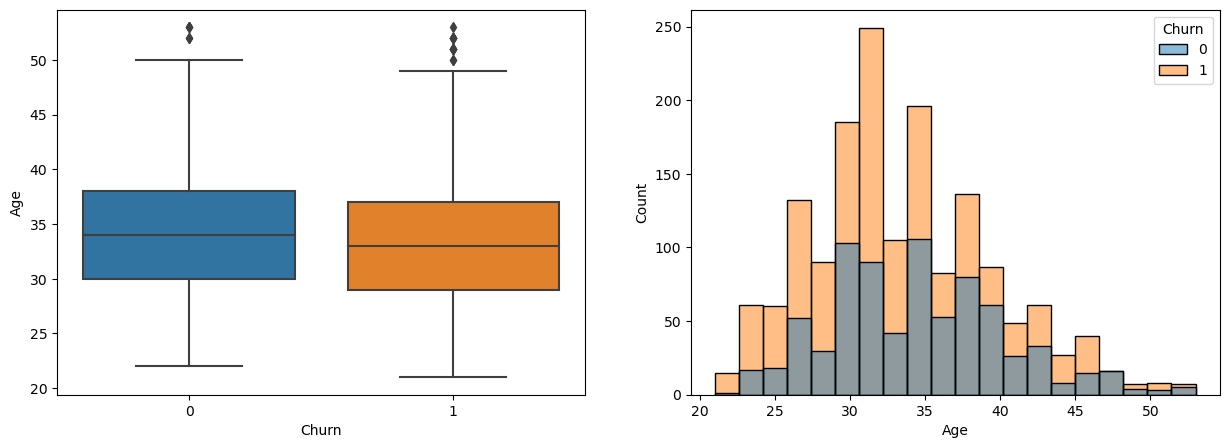

INSIGHTS:
Mean of Age for 1 at 33.34 is lower than that for 0 at 34.33

Age and Churn  has some relation has been also seen through hypothesis testing and results shown above


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,763.0,34.328965,5.81545,22.0,30.0,34.0,38.0,53.0
1,1614.0,33.336431,5.96395,21.0,29.0,33.0,37.0,53.0


In [58]:
# Age vs Churn

categorical_biv('Churn', 'Age')

>- Mean and median ages of drivers who quit is 33 while those who stayed is 34. 
>- Age and churn seem to be related as established with the help 2 sample T-test

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.6924018462751158

It means Gender and Churn are unrelated and independent of each other


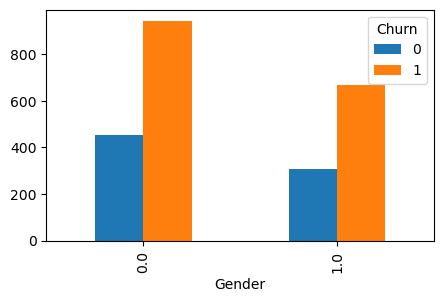

Churn,0,1,All
Gender,,,
0.0,454,945,1399
1.0,309,669,978
All,763,1614,2377


In [59]:
# Gender vs Churn

both_categorical('Gender', 'Churn')

>- Both male and female drivers showed high churn, i.e. double to those who stayed
>- It was seen through hypothesis testing that gender did not impact churn of drivers

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.017265189848775828

It means City and Churn are related and dependent on each other


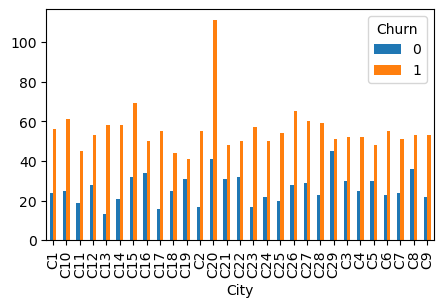

In [60]:
# City vs Churn

pd.crosstab(df['City'], df['Churn']).plot(kind='bar',figsize = [5,3])

p_val = chi_squared('City', 'Churn')
plt.show() 

>- From Chi-Squared test, it was found that city did have an impact on Churn of drivers

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.4467248694487944

It means Education_Level and Churn are unrelated and independent of each other


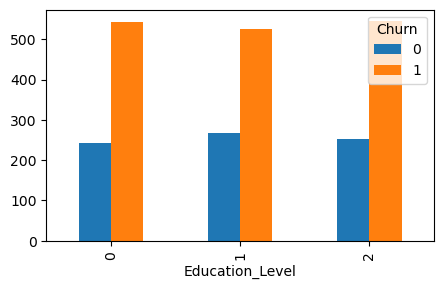

Churn,0,1,All
Education_Level,,,
0,242,542,784
1,268,526,794
2,253,546,799
All,763,1614,2377


In [61]:
# Education level vs Churn

both_categorical('Education_Level', 'Churn')

>- Drivers from all education levels saw similar proportion of Churn showing no impact of education level on Churn

Null Hypothesis: Mean of Income values for categories 1 and 0 is same
Alternate Hypothesis: Mean of values for categories 1 and 0 is not same

p value for two tailed T test is:  1.4194624969280012e-18

Mean of Income and Churn are different for both categories therefore Income has some relation with Churn


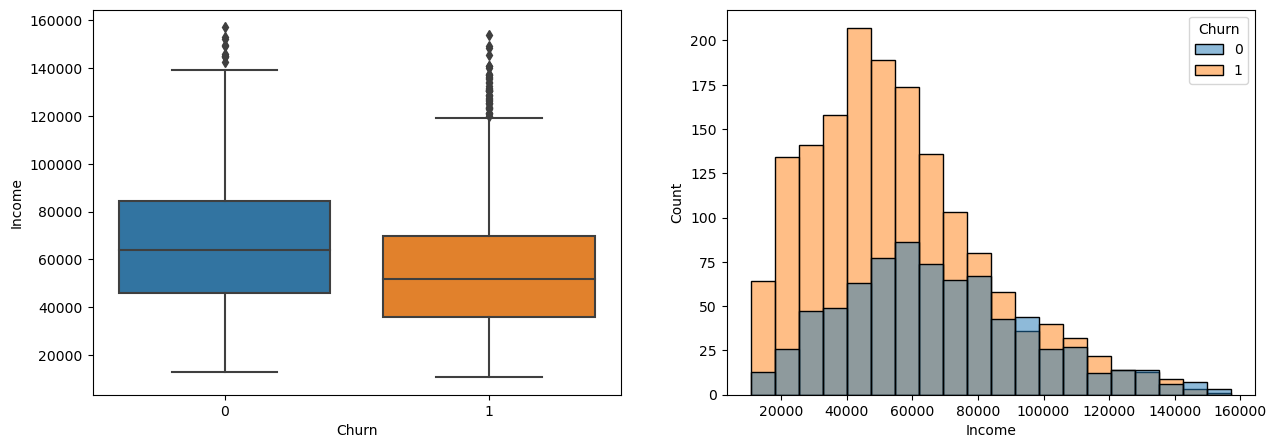

INSIGHTS:
Mean of Income for 1 at 55338.01 is lower than that for 0 at 67362.05

Income and Churn  has some relation has been also seen through hypothesis testing and results shown above


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,763.0,67362.052425,29055.974740,12938.0,46124.00,63918.0,84535.00,157124.0
1,1614.0,55338.007435,26787.990795,10747.0,36136.25,51630.0,69756.25,153766.0


In [62]:
# Income vs Churn

categorical_biv('Churn', 'Income')

>- Mean and median income for drivers who quit was much lower than those who stayed which is along expectations
>- Lower income could have been one of the reasons behind the churn

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 5.739973510401881e-10

It means Joining Designation and Churn are related and dependent on each other


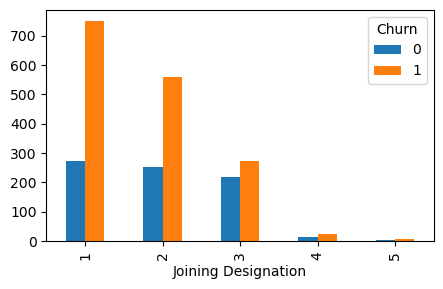

Churn,0,1,All
Joining Designation,,,
1,274,751,1025
2,253,560,813
3,219,274,493
4,14,22,36
5,3,7,10
All,763,1614,2377


In [63]:
# Joining Designation vs Churn

both_categorical('Joining Designation', 'Churn')

>- Proportion of drivers who quit decreases as joining designation of the drivers improves.
>- Higher number of observations in lower joining designations could have an impact on this observation

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 8.16533730235212e-27

It means Grade and Churn are related and dependent on each other


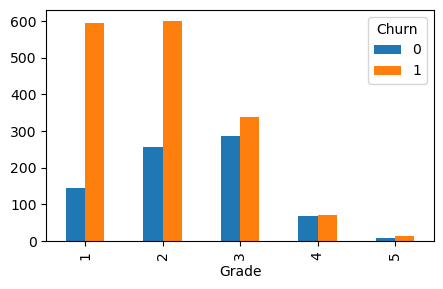

Churn,0,1,All
Grade,,,
1,145,595,740
2,256,600,856
3,285,337,622
4,68,70,138
5,9,12,21
All,763,1614,2377


In [64]:
# Grade vs Churn

both_categorical('Grade', 'Churn')

>- Proportion of drivers who quit decreases as grade increases
>- This is in line with observations on monthly income and joining designation
>- Improvement in grade, joining designation and monthly income may help in retaining existing drivers

Null Hypothesis: Mean of Total Business Value values for categories 1 and 0 is same
Alternate Hypothesis: Mean of values for categories 1 and 0 is not same

p value for two tailed T test is:  9.9101490132657e-54

Mean of Total Business Value and Churn are different for both categories therefore Total Business Value has some relation with Churn


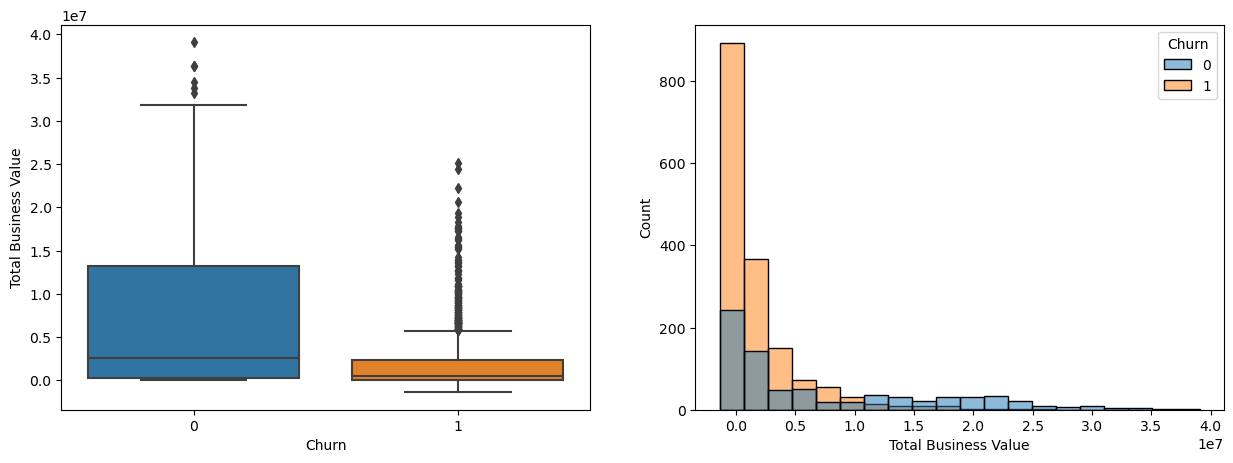

INSIGHTS:
Mean of Total Business Value for 1 at 1878968.85 is lower than that for 0 at 7402722.31

Total Business Value and Churn  has some relation has been also seen through hypothesis testing and results shown above


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,763.0,7.402722e+06,8.941637e+06,0.0,235060.0,2607050.0,13258180.0,39101530.0
1,1614.0,1.878969e+06,3.263762e+06,-1385530.0,0.0,456325.0,2294615.0,25121990.0


In [65]:
# Total Business Value vs Churn

categorical_biv('Churn', 'Total Business Value')

>- The Total Business Value brought by drivers who quit was much lower than drivers who were retained
>- Almost all negative values of TBV which arises from debt or cancellations was seen in drivers who quit
>- This shows poor performance and lack of revenue could have led to churn

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 8.477927503950843e-143

It means Quarterly Rating and Churn are related and dependent on each other


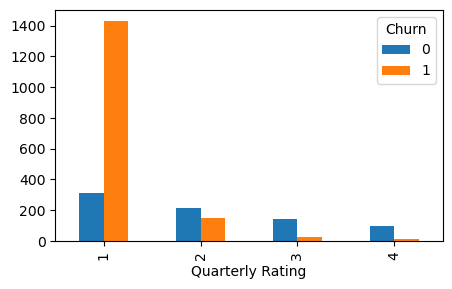

Churn,0,1,All
Quarterly Rating,,,
1,311,1431,1742
2,215,146,361
3,142,27,169
4,95,10,105
All,763,1614,2377


In [66]:
# Quarterly Rating vs Churn

both_categorical('Quarterly Rating', 'Churn')

>- As majority of observations belong to quarterly rating of 1, most drivers who quit also belonged to that category
>- This can lead to model giving higher importance to quarterly rating

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 4.342025959484546e-86

It means quarterly_rating_trend and Churn are related and dependent on each other


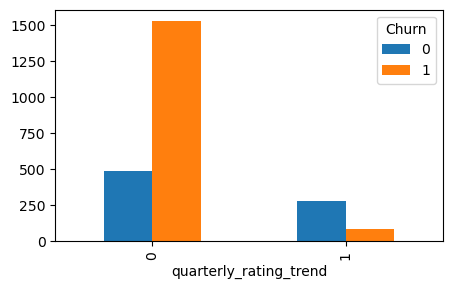

Churn,0,1,All
quarterly_rating_trend,,,
0,488,1532,2020
1,275,82,357
All,763,1614,2377


In [67]:
# quarterly_rating_trend vs Churn

both_categorical('quarterly_rating_trend', 'Churn')

>- As most drivers did not see raise in quarterly rating, the number of drivers in that category is high.
>- Even within those drivers who say rise in quarterly ratings, one-third quit
>- More data may be needed about drivers who received hike in ratings to see impact

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 7.246201725470039e-17

It means monthly_income_trend and Churn are related and dependent on each other


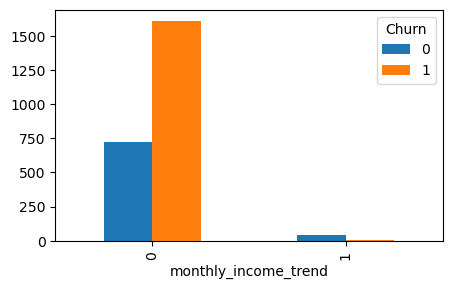

Churn,0,1,All
monthly_income_trend,,,
0,724,1611,2335
1,39,3,42
All,763,1614,2377


In [68]:
# monthly_income_trend vs Churn

both_categorical('monthly_income_trend', 'Churn')

>- Only 42 drivers out of all saw a hike in monthly income which makes data imbalanced
>- Out of thise only 3 quit the job while others were retained.
>- Data is too small to comment

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 2.2198932573381567e-08

It means month_of_joining and Churn are related and dependent on each other


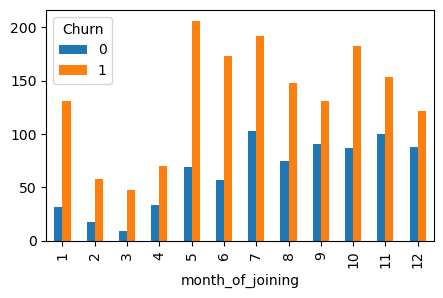

Churn,0,1,All
month_of_joining,,,
1,32,131,163
2,18,58,76
3,9,48,57
4,34,70,104
5,69,206,275
6,57,173,230
7,103,192,295
8,75,148,223
9,91,131,222


In [69]:
# month_of_joining vs Churn

both_categorical('month_of_joining', 'Churn')

### Now we will be checking correlation between independent variables:

In [77]:
# storing numerical and categorical columns in lists separately

num_cols = df.select_dtypes(include = np.number).columns
cat_cols = df.select_dtypes(include = 'object').columns

Text(0.5, 1.0, 'Correlation factor for all variables')

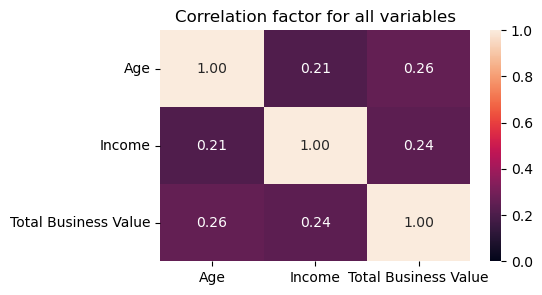

In [76]:
# comparing numerical features using correlation and heatmap

plt.figure(figsize=[5,3])

sns.heatmap(df.corr(method= 'spearman'), annot= True, fmt = '.2f', vmin = 0)
plt.title('Correlation factor for all numerical variables')


>- All the independent numerical variables are not correlated to each other

#### Checking correlation between some of the categorical variables

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.8903443264606686

It means Education_Level and Gender are unrelated and independent of each other


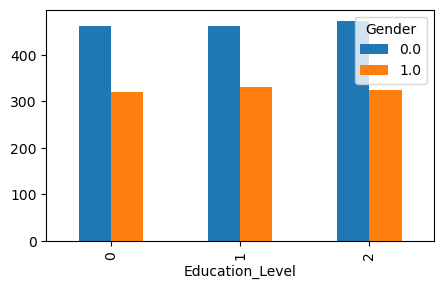

Gender,0.0,1.0,All
Education_Level,,,
0,463,321,784
1,462,332,794
2,474,325,799
All,1399,978,2377


In [84]:
# Gender vs Education_Level

both_categorical('Education_Level', 'Gender')

>- All the three education levels have similar proportion of male and female drivers
>- Both variables are not correlated

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.2175330536566529

It means Joining Designation and Gender are unrelated and independent of each other


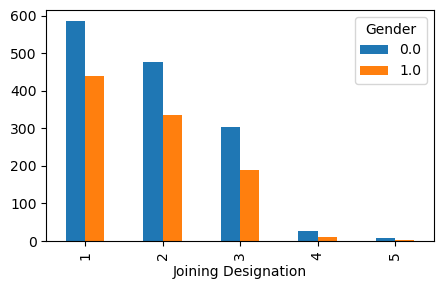

Gender,0.0,1.0,All
Joining Designation,,,
1,586,439,1025
2,477,336,813
3,303,190,493
4,26,10,36
5,7,3,10
All,1399,978,2377


In [85]:
# Gender vs Joining Designation

both_categorical('Joining Designation', 'Gender')

>- Drivers from both genders are equally distributed in all joining designations
>- Both variables are not correlated

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.9809674232954045

It means Grade and Gender are unrelated and independent of each other


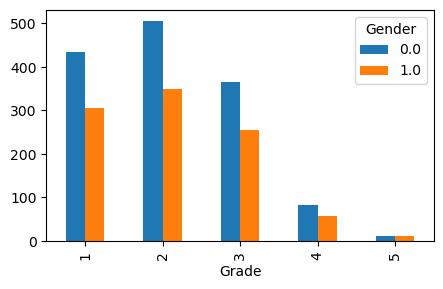

Gender,0.0,1.0,All
Grade,,,
1,434,306,740
2,506,350,856
3,366,256,622
4,82,56,138
5,11,10,21
All,1399,978,2377


In [86]:
#  Gender vs Grade

both_categorical('Grade', 'Gender')

>- Drivers from both genders are equally distributed in all grades and there is no correlation between variables

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.29911709883085025

It means Quarterly Rating and Gender are unrelated and independent of each other


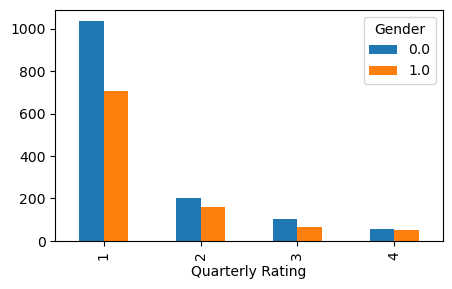

Gender,0.0,1.0,All
Quarterly Rating,,,
1,1037,705,1742
2,203,158,361
3,104,65,169
4,55,50,105
All,1399,978,2377


In [87]:
# Gender vs Quarterly Rating

both_categorical('Quarterly Rating', 'Gender')

>- Drivers from both genders have received similar quarterly ratings and there is no correlation between variables

Null Hypothesis: Mean of Income values for categories 0.0 and 1.0 is same
Alternate Hypothesis: Mean of values for categories 0.0 and 1.0 is not same

p value for two tailed T test is:  0.2780059705596297

Mean of Income and Gender are same for both categories therefore Income has minimal or no impact on Gender


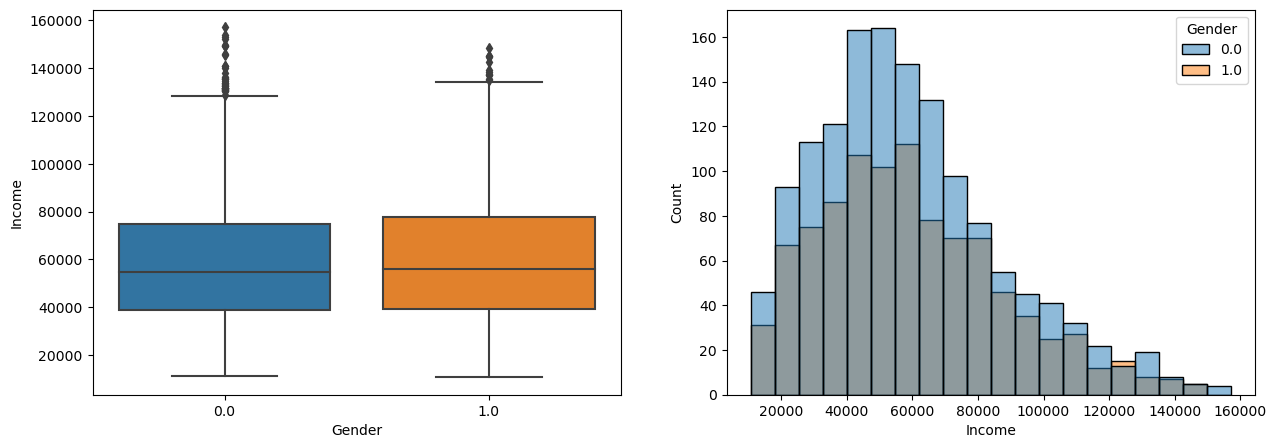

INSIGHTS:
Mean of Income for 0.0 at 58837.97 is lower than that for 1.0 at 59712.13

Income has minimal or no impact on Gender has been also seen through hypothesis testing and results shown above


,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
0.0,1399.0,58837.971408,28174.528367,11068.0,38967.5,54632.0,74809.0,157124.0
1.0,978.0,59712.134969,27991.930262,10747.0,39177.0,56025.5,77568.5,148588.0


In [89]:
# Gender vs Income

categorical_biv('Gender','Income')

>- There seems to be no impact of gender on income as seen in chart as well as through hypothesis testing

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 0.41459568539893255

It means Education_Level and quarterly_rating_trend are unrelated and independent of each other


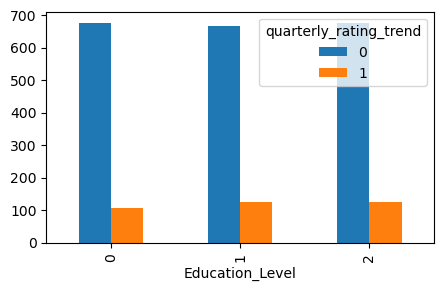

quarterly_rating_trend,0,1,All
Education_Level,,,
0,677,107,784
1,668,126,794
2,675,124,799
All,2020,357,2377


In [90]:
# Education_Level vs quarterly_rating_trend

both_categorical('Education_Level', 'quarterly_rating_trend')

>- There seems to be no impact of education level on quarterly rating trend

Null Hypothesis: Mean of Total Business Value values for categories 2 and 0 is same
Alternate Hypothesis: Mean of values for categories 2 and 0 is not same

p value for two tailed T test is:  0.830657525290633

Mean of Total Business Value and Education_Level are same for both categories therefore Total Business Value has minimal or no impact on Education_Level


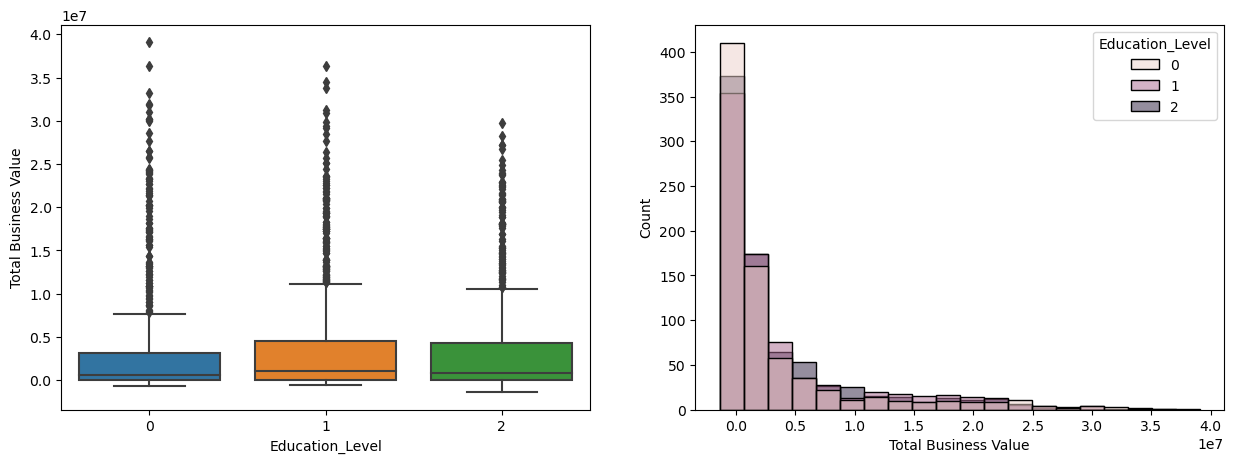

INSIGHTS:
Mean of Total Business Value for 2 at 3456912.47 is greater than that for 0 at 3437932.55

Total Business Value has minimal or no impact on Education_Level has been also seen through hypothesis testing and results shown above


,count,mean,std,min,25%,50%,75%,max
Education_Level,,,,,,,,
0,784.0,3.437933e+06,6.514661e+06,-645150.0,0.0,566930.0,3080855.0,39101530.0
1,794.0,4.059850e+06,6.591591e+06,-608240.0,0.0,1031010.0,4494060.0,36351110.0
2,799.0,3.456912e+06,5.711195e+06,-1385530.0,0.0,860000.0,4248255.0,29694630.0


In [92]:
# Education_Level vs Total Business Value

categorical_biv('Education_Level', 'Total Business Value')

>- Education level saw no impact on the total business value brought in by drivers

Null Hypothesis: Mean of Total Business Value values for categories 1 and 2 is same
Alternate Hypothesis: Mean of values for categories 1 and 2 is not same

p value for two tailed T test is:  0.818001435375127

Mean of Total Business Value and Grade are same for both categories therefore Total Business Value has minimal or no impact on Grade


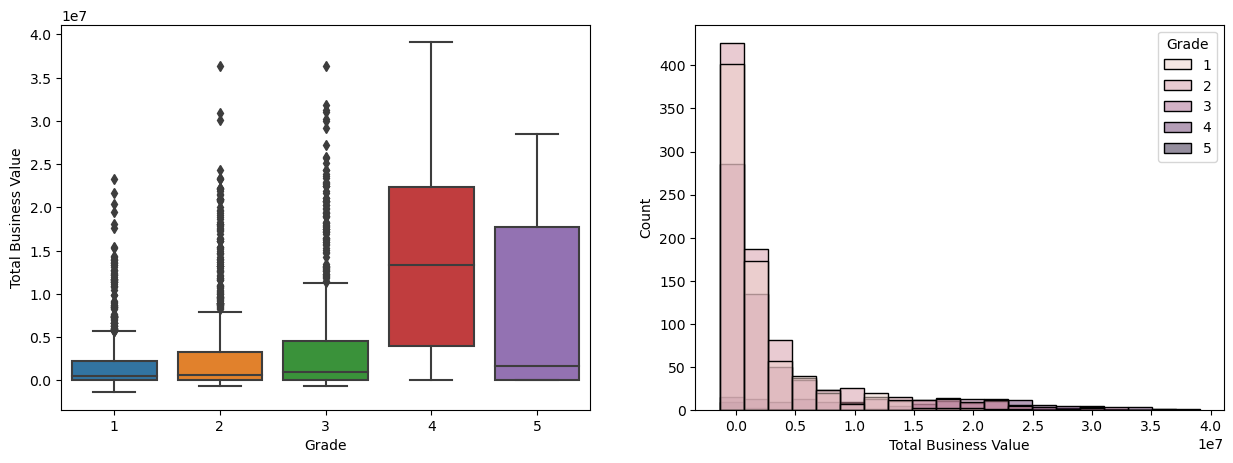

INSIGHTS:
Mean of Total Business Value for 1 at 2048274.78 is lower than that for 2 at 3051841.93

Total Business Value has minimal or no impact on Grade has been also seen through hypothesis testing and results shown above


,count,mean,std,min,25%,50%,75%,max
Grade,,,,,,,,
1,740.0,2.048275e+06,3.526647e+06,-1385530.0,0.0,475930.0,2266422.5,23230860.0
2,856.0,3.051842e+06,5.287103e+06,-645150.0,0.0,654315.0,3253267.5,36389370.0
3,622.0,3.995865e+06,6.668544e+06,-608240.0,0.0,943935.0,4535325.0,36351110.0
4,138.0,1.358214e+07,1.019655e+07,0.0,4016625.0,13384855.0,22301715.0,39101530.0
5,21.0,9.193791e+06,1.101141e+07,0.0,0.0,1675670.0,17681490.0,28502790.0


In [96]:
# Grade vs Total Business Value

categorical_biv('Grade','Total Business Value')

>- Drivers in Grade 4 have highest mean and median total business value but only 138 out of 2377 drivers are part of that grade

Null Hypothesis: Both the variables are independent of each other

Alternate Hypothesis: Both the variables are related and dependent on each other
p value for Chi Square test is: 4.893785561319253e-09

It means Grade and quarterly_rating_trend are related and dependent on each other


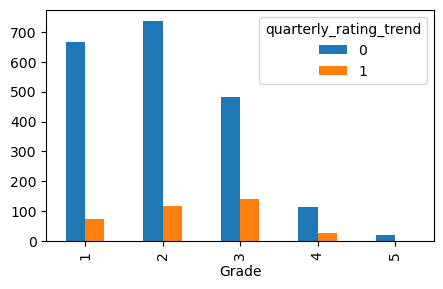

quarterly_rating_trend,0,1,All
Grade,,,
1,666,74,740
2,738,118,856
3,483,139,622
4,113,25,138
5,20,1,21
All,2020,357,2377


In [97]:
# Grade vs quarterly_rating_trend

both_categorical('Grade', 'quarterly_rating_trend')

>- Highest number of drivers who saw a raise in quarterly rating were from Grade 3 followed by grade 2
>- Grade 1 with highest number of drivers saw lowest number of quarterly rating inmprovements

## 2. Data Preprocessing:

### One Hot encoding of Categorical variables

In [102]:
# finding number of unique values in categorical variable City

df['City'].nunique()

29

>- Dataset has information on drivers from 29 cities.
>- One hot encoding will lead to formation of 28 new columns

In [105]:
df_orig = df.copy()

In [104]:
df.shape

(2377, 13)

In [107]:
# City- One Hot Encoding

df_city = pd.get_dummies(df['City'], drop_first=True, prefix='City')

df = pd.concat([df,df_city], axis = 1)

df = df.drop('City', axis = 1)

In [114]:
df.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,quarterly_rating_trend,monthly_income_trend,Churn,month_of_joining,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,28.0,0.0,2,57387,1,1,1715580,2,0,0,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,31.0,0.0,2,67016,2,2,0,1,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,43.0,0.0,2,65603,2,2,350000,1,0,0,1,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29.0,0.0,0,46368,1,1,120360,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,31.0,1.0,1,78728,3,3,1265000,2,1,0,0,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Standard scaling of training data

In [132]:
# Creation of independent and target variable datasets

X = df.drop('Churn', axis = 1)
y = df['Churn']
y = y.astype('int')

In [475]:
# creating training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state= 1)

In [476]:
X_train.reset_index(drop= True, inplace = True)
X_test.reset_index(drop= True, inplace = True)

In [477]:
#using Standard scaling to scale numerical data

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)

In [478]:
X_test = pd.DataFrame(sc.transform(X_test),columns = X_test.columns)

In [424]:
X_train.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,quarterly_rating_trend,monthly_income_trend,month_of_joining,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,-0.095035,1.200128,-1.208476,-1.216530,-0.982755,-1.167063,0.161860,-0.527748,-0.423415,-0.128754,1.159973,-0.188157,-0.164355,-0.177399,-0.174219,-0.18965,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,5.114405,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219
1,-0.434303,1.200128,0.010258,-0.532354,-0.982755,-1.167063,-0.448316,-0.527748,-0.423415,-0.128754,1.159973,-0.188157,6.084406,-0.177399,-0.174219,-0.18965,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219
2,-0.095035,-0.833244,1.228992,-0.460671,1.410861,0.985860,-0.579937,-0.527748,-0.423415,-0.128754,-1.079040,-0.188157,-0.164355,-0.177399,-0.174219,-0.18965,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,4.934234,-0.174219
3,-0.095035,-0.833244,0.010258,0.793695,-0.982755,0.985860,-0.080173,-0.527748,-0.423415,-0.128754,-1.079040,-0.188157,-0.164355,-0.177399,-0.174219,-0.18965,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,-0.210963,-0.198408,5.314711,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219
4,0.244234,-0.833244,0.010258,0.178041,0.214053,-0.090602,-0.414123,-0.527748,-0.423415,-0.128754,-0.119463,-0.188157,-0.164355,-0.177399,-0.174219,-0.18965,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,4.740162,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219


#### Data Pre-processing completed as all the variables were encoded or scaled and train-test split was done
>- **Class Imbalance Treatment will be done while running the models by providing class_weights = 'balanced' which will take care of the class imbalance of 1:2 (0:1 classes) in the target variable**

______

## 3. Model Building

### For Bagging Algorithm, we will be building a Random Forest Classifier based model
>- We will be doing hyperparameter tuning in the the algorithm to arrive at the best model
>- Hyperparameters will be **max_depth, min_samples_leaf, min_samples_split, n_estimators, max_features**
>- While conducting grid search, **we will be checking the f1 score of the model to find best parameters**

In [201]:
# Training a random forest model with default parameters

rf = RandomForestClassifier(class_weight= 'balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [204]:
# Look at parameters used by our current random forest

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [195]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       162
           1       0.83      0.92      0.87       314

    accuracy                           0.83       476
   macro avg       0.82      0.78      0.80       476
weighted avg       0.82      0.83      0.82       476



### Insights on model with default parameters of sklearn RandomForest Classifier:
>- Model gave very good results with default parameters
>- accuracy of 0.83 and f1-score of 0.87 are very good results
>- This model can be used as benchmark to beat by other models

#### Using Grid Search crossvalidation for hyperparameter tuning on Random Forest Model

In [125]:
## creating cross validation folds 

folds = KFold(n_splits=5,shuffle=True, random_state=1 )

In [226]:
# Grid Search on parameters

n_estimators = [int(x) for x in range(200,2000,200)]  # number of trees in the random forest
max_features = ['log2', 'sqrt']  # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]  # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]  # minimum sample number to split a node
min_samples_leaf = [1, 3, 4]  # minimum sample number that can be stored in a leaf node
bootstrap = [True, False]    # method used to sample data points


params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap}

rf = RandomForestClassifier(class_weight= 'balanced')

grid_search = RandomizedSearchCV(estimator= rf,
                                param_distributions= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True,
                                n_iter= 100,
                                random_state= 1
                                )

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=1, return_train_score=True, scoring='f1',
                   verbose=1)

In [227]:
rf_1 = grid_search.best_estimator_

In [228]:
grid_search.best_params_


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [229]:
y_pred = rf_1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70       162
           1       0.83      0.91      0.87       314

    accuracy                           0.82       476
   macro avg       0.80      0.77      0.78       476
weighted avg       0.81      0.82      0.81       476



>- Results were almost same as that of the model with default parameters
>- **Conducting finer tuning of the above hyperparameters to find better results**

In [429]:
n_estimators = [int(x) for x in range(900,1101,20)]  # number of trees in the random forest
max_depth = [int(x) for x in range(100,120,2)]  # maximum number of levels allowed in each decision tree
min_samples_split = [1, 2, 3]  # minimum sample number to split a node
min_samples_leaf = [1, 2, 3]  # minimum sample number that can be stored in a leaf node

rf = RandomForestClassifier(class_weight= 'balanced', random_state= 2)

params = {'n_estimators': n_estimators,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          }

grid_search = RandomizedSearchCV(estimator= rf,
                                param_distributions= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True,
                                n_iter= 100,
                                random_state= 3
                            )

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\krist\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
155 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
155 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\krist\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\krist\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterato

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [100, 102, 104, 106, 108,
                                                      110, 112, 114, 116, 118],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [1, 2, 3],
                                        'n_estimators': [900, 920, 940, 960,
                                                         980, 1000, 1020, 1040,
                                                         1060, 1080, 1100]},
                   random_state=3, return_train_score=True, scoring='f1',
                   verbose=1)

In [431]:
rf_2 = grid_search.best_estimator_

In [430]:
# printing best parameters

grid_search.best_params_

{'n_estimators': 1040,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 102}

>- Thus Random Forest  Model with above mentioned parameters is found to give the best results in terms of f1 score
>- This was confirmed through grid search and cross validation using 5 folds.


In [447]:
rf_final = RandomForestClassifier(class_weight= 'balanced',
                                 n_estimators = 1040,
                                 min_samples_split = 3,
                                 min_samples_leaf = 1,
                                 max_depth = 102,
                                 )
rf_final.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=102,
                       min_samples_split=3, n_estimators=1040)

### Random Forest Model Performance Evaluation

In [448]:
# calculating predicted target values

y_pred = rf_final.predict(X_test)

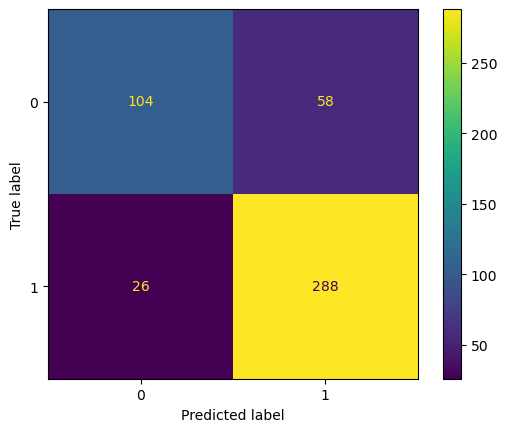

In [433]:
# printing confusion matrix for the model

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm )
disp.plot()

### Insights from Confusion matrix:
>- **Model has low number of False negatives which is critical for business as it would like to avoid as much churn as possible.**

In [434]:
# printing classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       162
           1       0.83      0.92      0.87       314

    accuracy                           0.82       476
   macro avg       0.82      0.78      0.79       476
weighted avg       0.82      0.82      0.82       476



### Insights from Classification report:
>- **Model gave a high accuracy of 0.82.**
>- As company would like to minimize its Churn, it is important to focus on reducing false negatives. 
>- **In that context, we will focus on Recall score which was high for our model at 0.92.**
>- **f1 score for our model was also high at 0.87 which is the harmonic mean of precision and recall.**

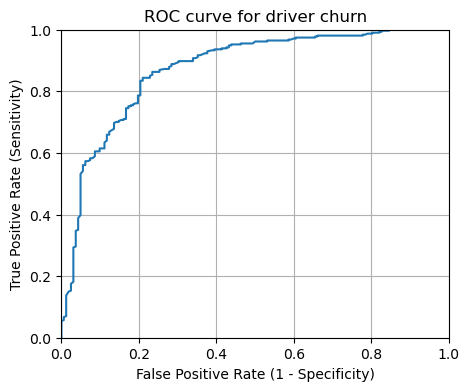

In [250]:
# Plotting the ROC curve
y_pred_prob = rf_2.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize= [5,4])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for driver churn')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [239]:
# Calculating ROC- AUC Score
roc_auc_score(y_test, y_pred_prob)

0.8739482582370056

### Insights from ROC Curve:
>- The ROC curve represents the performance of model for different thresholds of probabilities
>- True positive rate (sensitivity) is plotted against false positive rate(specificity) to obtain the curve
>- **Model showed a high value of AUC ROC score at 0.87** 
>- An ideal model has an AU-ROC value of 1 and our model scored 0.87
>- The ROC curve was steep which means model could detect more true positives with lower false positives. 
>- This score being independent of threshold value of probability between 2 classes, it is more robust and a better measure of our model's performance compared to accuracy and f1 scores.

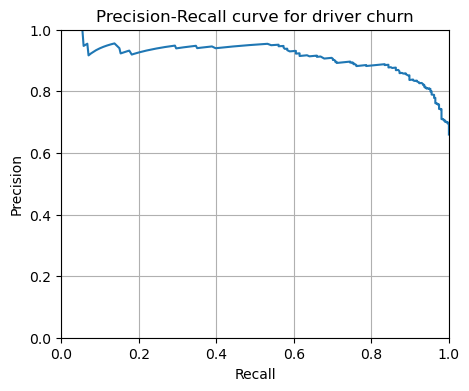

In [251]:
#plotting the precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize= [5,4])
plt.plot(recall, precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Precision-Recall curve for driver churn')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

In [252]:
#calculating area under precision recall curve
auc(recall, precision)

0.9147496543034432

### Insights from Precision Recall Curve:
>- Precision Recall curve is plotted for different thresholds of probabilities for the model
>- **Precision Recall curve is usually used when data is imbalanced as AU-ROC can be deceptive in such cases.**
>- Area under PR curve also represents performance of the model when data is imbalanced
>- **Our model has area under PR Curve value of 0.91 which can be considered as very good**

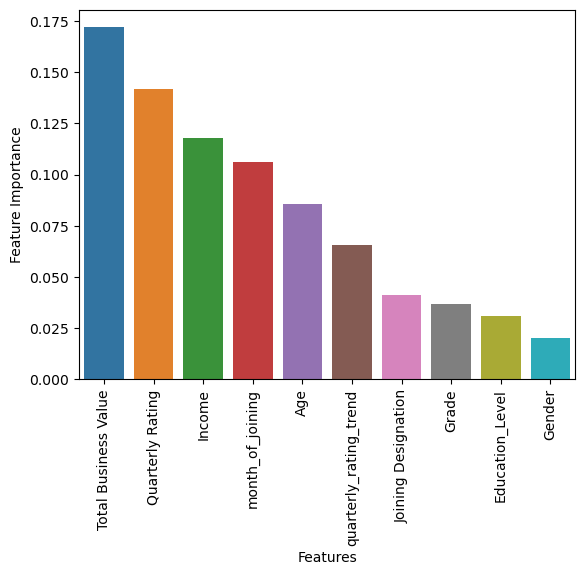

<Figure size 400x300 with 0 Axes>

In [267]:
# Checking Feature Importance
feat_imp = pd.DataFrame({'Features': X.columns, 'Feature Importance': rf_2.feature_importances_}).sort_values('Feature Importance', ascending = False).iloc[0:10]
sns.barplot(x = 'Features', y = 'Feature Importance', data = feat_imp)
plt.xticks(rotation = 90)
plt.figure(figsize = [4,3])
plt.show()

### Insights: 
>- According our model, top 10 features by importance in determining Churn are shown above
>- **Total Business Value was the most important factor followed by quarterly rating and Income in determing churn in drivers.**

### Calculating Lift and Gains Achieved by the model on test data:
>- Dividing data in 10 quantiles and arranging in decreasing order of predicted probability

>- **Gain gives us an information on how many positive cases model could detect in each decile**
>-**Lift is the improvement by model in proportion to prediction done without use of model for each decile.**

>- Then we check what percent of values in each decile are predicted correctly
>- Percent of events correctly predicted gives the efficiency of the model
>- **Ideally most positive events (Churn) should be detected in top few deciles**
>- **That will mean we can focus on drivers falling in those deciles and need not reach out to all the drivers**
>- **It helps in achieving optimization of resources consumed in retaining drivers**

In [453]:

y_pred_prob = rf_final.predict_proba(X_test)[:, 1]
y_test.reset_index(drop= True, inplace= True)
X_test.reset_index(drop= True, inplace= True)

X_test_res = X_test.copy()
X_test_res.reset_index(drop= True, inplace= True)
X_test_res['y_test'] = y_test
X_test_res['predicted_probability'] = y_pred_prob
X_test_res = X_test_res.sort_values(by='predicted_probability', ascending=False)
X_test_res['decile'] = pd.qcut(X_test_res['predicted_probability'], 10)

X_test_res['row_num'] = np.arange(1, X_test_res.shape[0]+1)
X_test_res['decile'] = 11 - np.ceil(X_test_res['row_num']/(X_test_res.shape[0]/10))
X_test_res.reset_index(drop= True, inplace = True)
X_test_res.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,quarterly_rating_trend,monthly_income_trend,month_of_joining,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,y_test,predicted_probability,decile,row_num
0,0.074600,-0.833244,-1.208476,-1.066521,-0.982755,-1.167063,-0.579937,-0.527748,-0.423415,-0.128754,-0.439322,-0.188157,-0.164355,-0.177399,-0.174219,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.998381,10.0,1
1,-0.095035,-0.833244,0.010258,-0.840471,-0.982755,-1.167063,-0.579937,-0.527748,-0.423415,-0.128754,-0.439322,-0.188157,-0.164355,-0.177399,-0.174219,5.272858,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.998381,10.0,2
2,1.770944,1.200128,1.228992,-0.431076,-0.982755,-1.167063,-0.437357,-0.527748,-0.423415,-0.128754,-0.119463,-0.188157,-0.164355,-0.177399,-0.174219,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,5.446218,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.994346,10.0,3
3,-0.603938,-0.833244,1.228992,-0.334374,-0.982755,-1.167063,-0.464805,-0.527748,-0.423415,-0.128754,-2.038617,-0.188157,-0.164355,-0.177399,-0.174219,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.991000,10.0,4
4,0.244234,1.200128,1.228992,-1.290827,-0.982755,-1.167063,-0.579937,-0.527748,-0.423415,-0.128754,-1.079040,-0.188157,-0.164355,-0.177399,-0.174219,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,5.446218,-0.18053,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.990475,10.0,5


In [455]:
lift = X_test_res.groupby('decile').agg( #Group by Deciles of Predicted Probabilties
[
    'count', #The total number of customers(data points) in the decile
    'sum', #The total number of bad customers(Risk=1)
]
)['y_test'].sort_index(ascending=False)
lift.columns = ['Number of Drivers','Churn']
lift['Cumulative Churn'] = lift['Churn'].cumsum() #Cumulative Sum of the number of bads
#Calculate Gain = Cumulative Percent of Events/Bads
lift['Percent of Events'] = lift['Churn']/lift['Churn'].sum()*100
lift['Gain'] = lift['Percent of Events'].cumsum() 
#Calculate Lift = Ratio of Bads to the number of data points in the decile
lift['Lift'] = lift['Gain']/np.array(range(10,100+10,10))
lift.head(10)

,Number of Drivers,Churn,Cumulative Churn,Percent of Events,Gain,Lift
decile,,,,,,
10.0,47,45,45,14.331210,14.331210,1.433121
9.0,48,45,90,14.331210,28.662420,1.433121
8.0,47,44,134,14.012739,42.675159,1.422505
7.0,48,44,178,14.012739,56.687898,1.417197
6.0,48,38,216,12.101911,68.789809,1.375796
5.0,47,36,252,11.464968,80.254777,1.337580
4.0,48,30,282,9.554140,89.808917,1.282985
3.0,47,19,301,6.050955,95.859873,1.198248
2.0,48,7,308,2.229299,98.089172,1.089880


### Insights:
>- **We can see that top 5 deciles or top 50% of the predictions by the model cover 80% of the churn.**
>- This means we can focus on only half of the entire drivers and still be ble to target 80% of the drivers who are expected to quit.

<AxesSubplot:xlabel='decile', ylabel='count'>

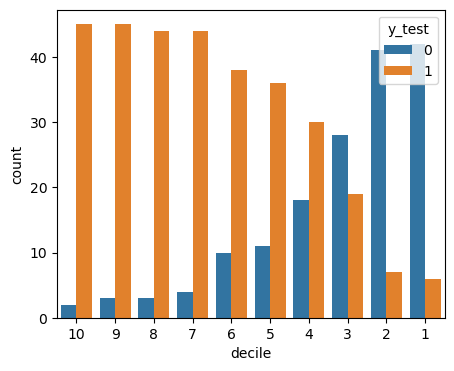

In [465]:
# Plotting the percent of churn in each decile 

plt.figure(figsize= [5,4])
sns.countplot(x = 'decile', hue = 'y_test', data =X_test_res ,order= range(10,0,-1) )

>- The same results in table are seen visually through a countplot
>- First 5 bars see highest number of positive (1) cases representing churn
>- As we move further to right, we can see number of negative cases increase compared to positive cases

______________

### For Boosting Algorithm, we will be building a XG Boost model
>- We will be doing hyperparameter tuning in the the algorithm to arrive at the best model
>- Hyperparameters will be **learning rate, max depth, sub sample, column sample by tree**
>- While conducting grid search, **we will be checking the f1 score of the model to find best parameters**
>- We will train model for different hyperparameters in each step adn try incremental improvement

>- **Class imbalance in XG Boost model is taken care by scale_pos_weight argument in XGBClassifier** :   
> XG Boost Documentation for scale_pos_weight: Balancing of positive and negative weights.

In [292]:
# training with default values of hyperparameters 

xgb = XGBClassifier(objective='binary:logistic' )
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [293]:
# finding accuracy score

xgb.score(X_test, y_test)

0.7794117647058824

In [294]:
# Look at parameters used by our current xgboost model
print('Parameters currently in use:\n')
pprint(xgb.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': None,
 'validate_parameters': 1,
 'verbosity': None}


In [295]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       162
           1       0.82      0.86      0.84       314

    accuracy                           0.78       476
   macro avg       0.76      0.74      0.75       476
weighted avg       0.78      0.78      0.78       476



>- Model with defalt values gave a f1 score of 0.84 and accuracy of 0.78
>- This can be considered as benchmark for hyperparameter tuning

In [269]:
## creating cross validation folds 

folds = KFold(n_splits=5,shuffle=True, random_state=1 )

>- training XG Boost model with learning rate and n_estimators first through grid search cross validation
>- **fixing learning rate and n_estimators to tune other parameters**

In [297]:
params = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
        'n_estimators': range(50,501,50)
        }

xgb = XGBClassifier(objective='binary:logistic', max_depth = 5, subsample = 0.8, 
                    colsample_bytree = 0.8, scale_pos_weight =1,min_child_weight=1, random_state = 1 )

grid_search = RandomizedSearchCV(estimator= xgb,
                                param_distributions= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True,
                                n_iter= 100,
                                random_state= 1
                            )

grid_search.fit(X_train, y_train)

C:\Users\krist\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.8,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None...
                                           max_delta_step=None, max_depth=5,
                                           max_leaves=None, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=1, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.5],
                                        'n_estimators': range(50, 501, 50)},
                   random_state=1, return_train_score=True, scoring='f1',
                   verbose=1)

In [298]:
# finding best parameters

grid_search.best_params_

{'n_estimators': 50, 'learning_rate': 0.1}

In [299]:
# further finetuning to find best learning rate and n_estimators

params = {'learning_rate': np.linspace(0.01,0.2,10),
        'n_estimators': range(50,151,20)
        }

xgb = XGBClassifier(objective='binary:logistic', max_depth = 5, subsample = 0.8, 
                    colsample_bytree = 0.8, scale_pos_weight =1,  min_child_weight=1, random_state = 1 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True,
                                
                            )

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inter...
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                         'n_estimators': range(50, 151, 20)},
             return_train_score=True, scoring='f1', verbose=1)

In [300]:
# finding best parameters

grid_search.best_params_

{'learning_rate': 0.11555555555555555, 'n_estimators': 50}

In [301]:
# test data accuracy

grid_search.best_estimator_.score(X_test, y_test)

0.8214285714285714

>- Tuning values of n_estimators and learning rate improved accuracy from 0.77 to 0.82
>- **Now we will tune max_depth, min_child_weight and gamma keeping n_estimators at 50 and learning rate 0.1 fixed**

In [312]:
params = {'max_depth': range(3,10),                #Maximum tree depth for base learners.
         'gamma':[i/10.0 for i in range(0,5)],     #Minimum split loss 
          'min_child_weight':range(1,6,2)          #Minimum sum of instance weight needed in a child.
        }

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, subsample = 0.8, 
                    colsample_bytree = 0.8, scale_pos_weight =1, random_state = 2 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True
                                )
                                
                            

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inter...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=2, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': range(3, 10),
                         'min_child_weight': range(1, 6, 2)},
             return_train_score=True, scoring='f1', verbose=1)

In [313]:
# finding best parameters

grid_search.best_params_

{'gamma': 0.4, 'max_depth': 7, 'min_child_weight': 1}

In [315]:
# further tuning of above hyper parameters

params = {'max_depth': [6,7,8],                #Maximum tree depth for base learners. 
          'min_child_weight':[1,2,3]          #Minimum sum of instance weight needed in a child.
        }

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, subsample = 0.8, 
                    colsample_bytree = 0.8, scale_pos_weight =1, random_state = 2, gamma = 0.4 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True
                                )
                                
                            

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     intera...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=2, ...),
             n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8], 'min_child_weight': [1, 2, 3]},
             return_train_score=True, scoring='f1', verbose=1)

In [316]:
# finding best parameters

grid_search.best_params_

{'max_depth': 7, 'min_child_weight': 1}

In [317]:
# test data accuracy

grid_search.best_estimator_.score(X_test, y_test)

0.8172268907563025

>- Values for max_depth, min_child_weight and gamma were found to be 7, 1 and 0.4
>- **Now we can tune subsample and colsample_bytree**

In [318]:
params = {'subsample':[i/10.0 for i in range(6,10)],        # Subsample ratio of the training instance
          'colsample_bytree':[i/10.0 for i in range(6,10)]  # Subsample ratio of columns when constructing each tree.
        }

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, 
                    scale_pos_weight =1, random_state = 3, gamma = 0.4, max_depth = 7, min_child_weight = 1 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True
                                )
                                
                            

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     inter...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=3, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             return_train_score=True, scoring='f1', verbose=1)

In [319]:
# finding best parameters

grid_search.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.6}

In [323]:
# further finetuning of subsample and colsample_bytree

params = {'subsample':[i/100 for i in range(55,70,5)],        # Subsample ratio of the training instance
          'colsample_bytree':[i/100 for i in range(55,70,5)]  # Subsample ratio of columns when constructing each tree.
        }

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, 
                    scale_pos_weight =1, gamma = 0.4, max_depth = 7, min_child_weight = 1 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True
                                )
                                
                            

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     inter...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.55, 0.6, 0.65],
                         'subsample': [0.55, 0.6, 0.65]},
             return_train_score=True, scoring='f1', verbose=1)

In [324]:
# finding best parameters

grid_search.best_params_

{'colsample_bytree': 0.55, 'subsample': 0.6}

In [328]:
# test data accuracy

grid_search.best_estimator_.score(X_test, y_test)

0.8214285714285714

>- Accuracy increased again once we tuned colsample_bytree and subsample values
>- **Now we can tune regularization parameters reg_alpha and reg_lambda separately to see if there is any improvement**

In [329]:
params = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]   # L1 regularization term on weights
        }

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, 
                    scale_pos_weight =1, gamma = 0.4, max_depth = 7, min_child_weight = 1,
                   colsample_bytree = 0.55, subsample = 0.6 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True
                                )
                                
                            

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.55,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     inter...
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1, param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
             return_train_score=True, scoring='f1', verbose=1)

In [330]:
# finding best parameters

grid_search.best_params_

{'reg_alpha': 0.05}

In [331]:
grid_search.best_estimator_.score(X_test, y_test)

0.8340336134453782

>- Accuracy of model increased from 0.82 to 0.83 when we introduced L1 Ridge regularization with alpha = 0.05
>- Now we can check the same for L2 regularization by varying reg_lambda

In [332]:
params = {'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]   # L2 regularization term on weights
        }

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, 
                    scale_pos_weight =1, gamma = 0.4, max_depth = 7, min_child_weight = 1,
                   colsample_bytree = 0.55, subsample = 0.6 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True
                                )
                                                       
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.55,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     inter...
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05]},
             return_train_score=True, scoring='f1', verbose=1)

In [333]:
# finding best parameters

grid_search.best_params_

{'reg_lambda': 0.05}

In [334]:
grid_search.best_estimator_.score(X_test, y_test)

0.8277310924369747

>- L2 regularization did not perform as well as L1 regularization did.
>- Before finalizing our model, we can check by introducing Elasticnet model keeping both L1 and L2 regularizations

In [336]:
params = {'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05],   # L2 regularization term on weights
        'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]   # L1 regularization term on weights
         }

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, 
                    scale_pos_weight =1, gamma = 0.4, max_depth = 7, min_child_weight = 1,
                   colsample_bytree = 0.55, subsample = 0.6 )

grid_search = GridSearchCV(estimator= xgb,
                                param_grid= params,
                                cv = folds,
                                scoring = 'f1',
                                n_jobs= -1,
                                verbose = 1,
                                return_train_score= True
                                )
                                                       
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.55,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.4, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     inter...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
                         'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05]},
             return_train_score=True, scoring='f1', verbose=1)

In [337]:
# finding best parameters

grid_search.best_params_

{'reg_alpha': 0.05, 'reg_lambda': 0.01}

In [338]:
grid_search.best_estimator_.score(X_test, y_test)

0.8214285714285714

>- Mixing both L1 and L2 regularization also did not give an accuracy score as good as L1 alone
>- **Therefore we will use L1 regularization with reg_alpha = 0.05.**

In [466]:
# creating model with tuned hyperparameters

xgb = XGBClassifier(objective='binary:logistic', n_estimators = 50, learning_rate = 0.1, 
                    scale_pos_weight =1, gamma = 0.4, max_depth = 7, min_child_weight = 1,
                   colsample_bytree = 0.55, subsample = 0.6, reg_alpha = 0.05 )

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.55,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

>- Thus XGBoost Model with optimised hyperparameters was created and parameters are mentioned above
>- It gave the best f1 score, accuracy score and it was confirmed through cross validation and checking on test data

### XGBoost Model Performance Evaluation

In [467]:
# calculating predicted target values

y_pred = xgb.predict(X_test)

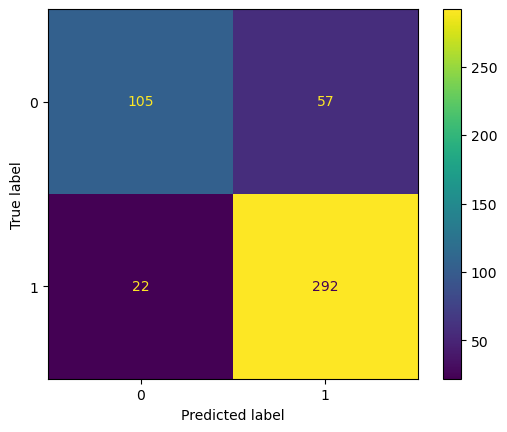

In [356]:
# printing confusion matrix for the model

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm )
disp.plot()

### Insights from Confusion matrix:
>- **Model has low number of False negatives which is critical for business as it would like to avoid as much churn as possible.**

In [357]:
# printing classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       162
           1       0.84      0.93      0.88       314

    accuracy                           0.83       476
   macro avg       0.83      0.79      0.80       476
weighted avg       0.83      0.83      0.83       476



### Insights from Classification report:
>- **Model gave a high accuracy of 0.83.**
>- As company would like to minimize its Churn, it is important to focus on reducing false negatives. 
>- **In that context, we will focus on Recall score which was high for our model at 0.93.**
>- **f1 score for our model was also high at 0.88 which is the harmonic mean of precision and recall.**
>- **All the scores for XGBoost model were better than Random Forest Model.**

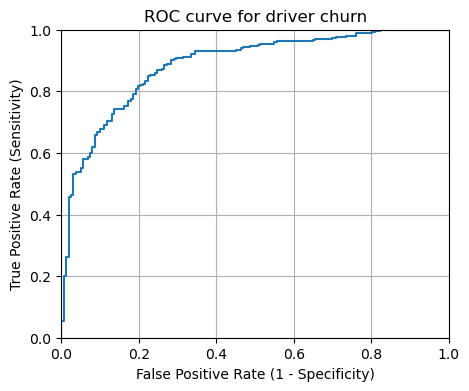

In [358]:
# Plotting the ROC curve
y_pred_prob = xgb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize= [5,4])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for driver churn')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [359]:
# Calculating ROC- AUC Score
roc_auc_score(y_test, y_pred_prob)

0.8862546198002673

### Insights from ROC Curve:
>- The ROC curve represents the performance of model for different thresholds of probabilities
>- True positive rate (sensitivity) is plotted against false positive rate(specificity) to obtain the curve
>- **Model showed a high value of AUC ROC score at 0.89** compared to 0.87 of RandomForest model 
>- An ideal model has an AU-ROC value of 1 and our model scored 0.89
>- The ROC curve was steep which means model could detect more true positives with lower false positives. 
>- This score being independent of threshold value of probability between 2 classes, it is more robust and a better measure of our model's performance compared to accuracy and f1 scores.

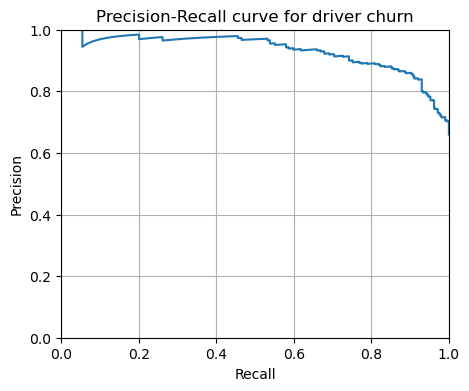

In [360]:
#plotting the precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize= [5,4])
plt.plot(recall, precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Precision-Recall curve for driver churn')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

In [361]:
#calculating area under precision recall curve
auc(recall, precision)

0.932335548538495

### Insights from Precision Recall Curve:
>- Precision Recall curve is plotted for different thresholds of probabilities for the model
>- **Precision Recall curve is usually used when data is imbalanced as AU-ROC can be deceptive in such cases.**
>- Area under PR curve also represents performance of the model when data is imbalanced
>- **Our model has area under PR Curve value of 0.93 which can be considered as very good** compared to 0.91 of Random Forest

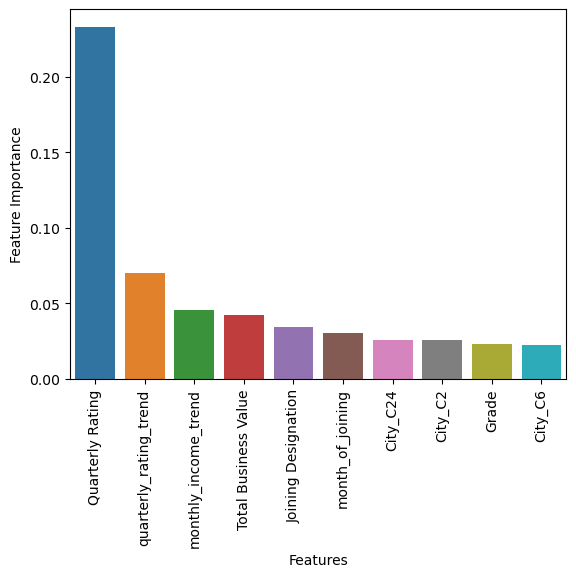

<Figure size 400x300 with 0 Axes>

In [362]:
# Checking Feature Importance
feat_imp = pd.DataFrame({'Features': X.columns, 'Feature Importance': xgb.feature_importances_}).sort_values('Feature Importance', ascending = False).iloc[0:10]
sns.barplot(x = 'Features', y = 'Feature Importance', data = feat_imp)
plt.xticks(rotation = 90)
plt.figure(figsize = [4,3])
plt.show()

### Insights on feature importance:
>- **Quarterly ratings play most important role in predicting churn. This could also be due to very high number of drivers with rating as 1 skewing the model.**
>- It is followed by quarterly rating trend and monthly income trend variables

### Calculating Lift and Gains Achieved by the model on test data:
>- Dividing data in 10 quantiles and arranging in decreasing order of predicted probability

>- **Gain gives us an information on how many positive cases model could detect in each decile**
>-**Lift is the improvement by model in proportion to prediction done without use of model for each decile.**

>- Then we check what percent of values in each decile are predicted correctly
>- Percent of events correctly predicted gives the efficiency of the model
>- **Ideally most positive events (Churn) should be detected in top few deciles**
>- **That will mean we can focus on drivers falling in those deciles and need not reach out to all the drivers**
>- **It helps in achieving optimization of resources consumed in retaining drivers**

In [479]:

y_pred_prob = xgb.predict_proba(X_test)[:, 1]
y_test.reset_index(drop= True, inplace= True)
X_test.reset_index(drop= True, inplace= True)

X_test_res = X_test.copy()
X_test_res.reset_index(drop= True, inplace= True)
X_test_res['y_test'] = y_test
X_test_res['predicted_probability'] = y_pred_prob
X_test_res = X_test_res.sort_values(by='predicted_probability', ascending=False)
X_test_res['decile'] = pd.qcut(X_test_res['predicted_probability'], 10)

X_test_res['row_num'] = np.arange(1, X_test_res.shape[0]+1)
X_test_res['decile'] = 11 - np.ceil(X_test_res['row_num']/(X_test_res.shape[0]/10))
X_test_res.reset_index(drop= True, inplace = True)
X_test_res.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,quarterly_rating_trend,monthly_income_trend,month_of_joining,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,y_test,predicted_probability,decile,row_num
0,-0.095035,-0.833244,0.010258,-0.840471,-0.982755,-1.167063,-0.579937,-0.527748,-0.423415,-0.128754,-0.439322,-0.188157,-0.164355,-0.177399,-0.174219,5.272858,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.180530,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.985733,10.0,1
1,2.958385,-0.833244,-1.208476,-1.698951,-0.982755,-1.167063,-0.515368,-0.527748,-0.423415,-0.128754,-0.759181,-0.188157,-0.164355,-0.177399,5.739898,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.180530,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.983073,10.0,2
2,-0.264669,-0.833244,1.228992,-1.412985,-0.982755,-1.167063,-0.651675,-0.527748,-0.423415,-0.128754,-0.759181,-0.188157,6.084406,-0.177399,-0.174219,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.180530,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.982417,10.0,3
3,0.074600,-0.833244,-1.208476,-1.066521,-0.982755,-1.167063,-0.579937,-0.527748,-0.423415,-0.128754,-0.439322,-0.188157,-0.164355,-0.177399,-0.174219,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,-0.180530,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.982171,10.0,4
4,1.770944,-0.833244,-1.208476,-0.695944,-0.982755,-1.167063,-0.476718,-0.527748,-0.423415,-0.128754,-1.718758,-0.188157,-0.164355,-0.177399,-0.174219,-0.189650,-0.216347,-0.18965,-0.182077,-0.177399,-0.17261,-0.18053,-0.268689,-0.17897,-0.17897,-0.183614,5.539254,-0.174219,-0.210963,-0.198408,-0.188157,-0.205463,-0.195526,-0.185139,-0.18053,-0.174219,-0.182077,-0.202666,-0.174219,1,0.981421,10.0,5


In [480]:
lift = X_test_res.groupby('decile').agg( #Group by Deciles of Predicted Probabilties
[
    'count', #The total number of customers(data points) in the decile
    'sum', #The total number of bad customers(Risk=1)
]
)['y_test'].sort_index(ascending=False)
lift.columns = ['Number of Drivers','Churn']
lift['Cumulative Churn'] = lift['Churn'].cumsum() #Cumulative Sum of the number of bads
#Calculate Gain = Cumulative Percent of Events/Bads
lift['Percent of Events'] = lift['Churn']/lift['Churn'].sum()*100
lift['Gain'] = lift['Percent of Events'].cumsum() 
#Calculate Lift = Ratio of Bads to the number of data points in the decile
lift['Lift'] = lift['Gain']/np.array(range(10,100+10,10))
lift.head(10)

,Number of Drivers,Churn,Cumulative Churn,Percent of Events,Gain,Lift
decile,,,,,,
10.0,47,46,46,14.649682,14.649682,1.464968
9.0,48,46,92,14.649682,29.299363,1.464968
8.0,47,47,139,14.968153,44.267516,1.475584
7.0,48,42,181,13.375796,57.643312,1.441083
6.0,48,38,219,12.101911,69.745223,1.394904
5.0,47,35,254,11.146497,80.891720,1.348195
4.0,48,31,285,9.872611,90.764331,1.296633
3.0,47,13,298,4.140127,94.904459,1.186306
2.0,48,10,308,3.184713,98.089172,1.089880


### Insights:
>- **We can see that top 5 deciles or top 50% of the predictions by the model cover 80% of the churn.**
>- This means we can focus on only half of the entire drivers and still be ble to target 80% of the drivers who are expected to quit.
>- The performance of XG Boost model is similar to Random Forest Model in terms of Lift and Gain it provided. 

<AxesSubplot:xlabel='decile', ylabel='count'>

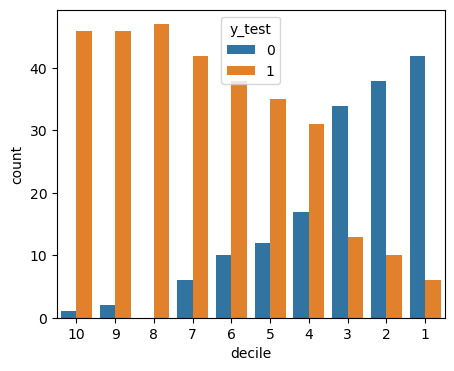

In [481]:
# Plotting the percent of churn in each decile 

plt.figure(figsize= [5,4])
sns.countplot(x = 'decile', hue = 'y_test', data =X_test_res ,order= range(10,0,-1) )

>- The same results in table are seen visually through a countplot
>- First 5 bars see highest number of positive (1) cases representing churn
>- As we move further to right, we can see number of negative cases increase compared to positive cases

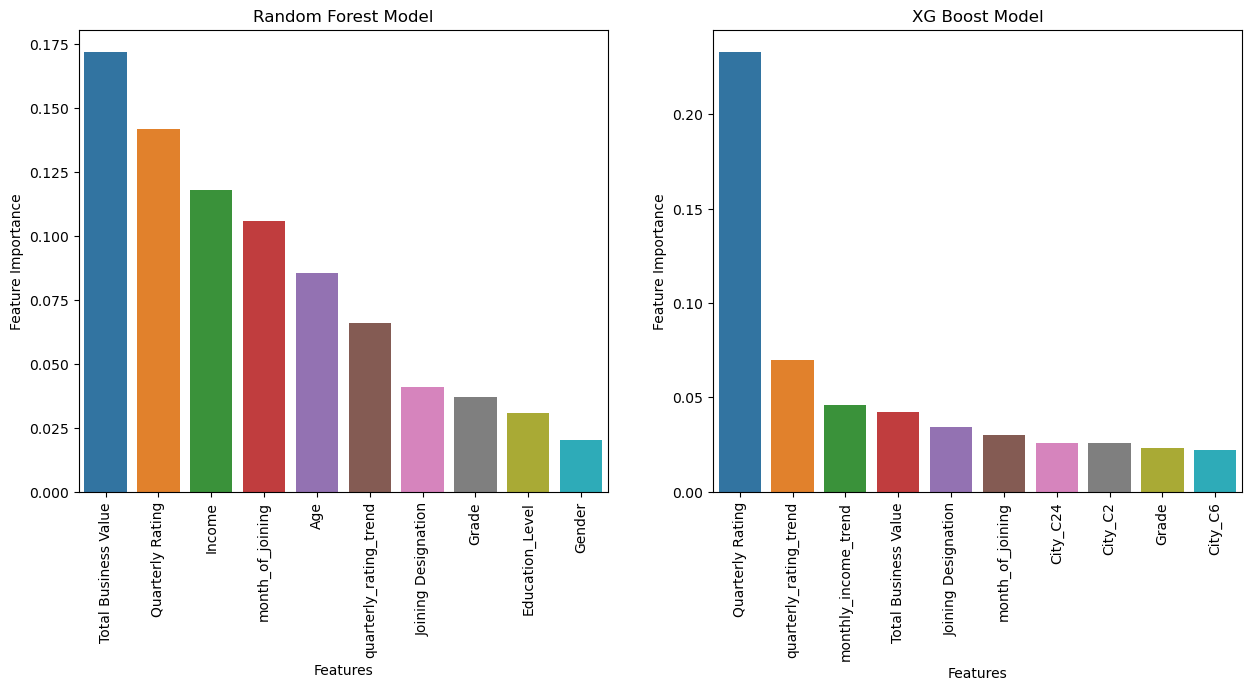

In [371]:
# Comparing Feature Importance given by Bagging and Boosting Algorithms

feat_imp1 = pd.DataFrame({'Features': X.columns, 'Feature Importance': rf_2.feature_importances_}).sort_values('Feature Importance', ascending = False).iloc[0:10]

plt.figure(figsize = [15,6])
plt.subplot(1,2,1)
sns.barplot(x = 'Features', y = 'Feature Importance', data = feat_imp1)
plt.xticks(rotation = 90)
plt.title('Random Forest Model')
plt.subplot(1,2,2)
sns.barplot(x = 'Features', y = 'Feature Importance', data = feat_imp)
plt.xticks(rotation = 90)
plt.title('XG Boost Model')
plt.show()

### Comparison between feature importance from both models:
>- Total business value, quarterly rating and income were top 3 most important features from Random Forest model
>- Quarterly rating, quarterly rating trend and monthly income trend  were top 3 most important features from XGBoost
>- **Top 10 most important features show major overlap like quarterly ratings, monthly income, joining designation, month of joining and grade.**

### End of Model Building and Evaluation:
>- **Both models gave high accuracy, f1 scores**
>- In the context of retaining drivers, **reducing False negatives becomes very important so that any driver about to quit may not be missed. This means Recall score is more important and both models gave recall scores of 0.91 and 0.93.**
>- Many common features were suggested by both models as important in determining Churn of drivers.
>- Overall XGBoost did a better job than Random Forest algorithm in performance. 

## 5. Actionable Insights and Recommendations:

### Actionable Insights:
#### Insights from EDA:
>1. **Data is imbalanced. As 68% of drivers are in class 1 (Churn) and 32% in class 0**. Values in class 1 are double to that of class 0.

>2. **Quarterly Rating**:  
>- Most drivers (73%) received a lower quarterly rating of 1. Very few drivers at 27% combined received the higher rating of 2, 3 and 4, and no driver received a rating of 5. 
>- Most drivers who quit also had a rating of 1. **Model could be skewed due to imbalanced data in this feature.**
>- Only 15% of the drivers received a raise in quarterly rating in the 2 years of data present
>- 85% of the drivers did not see any improvement in their quarterly ratings
>- This might reflect on the quality of drivers or the rating process of the organization

>3. **Monthly Income**:
>- Only 1.8% of the drivers saw a raise in monthly income over 2 years
>- 98% drivers did not see any growth in monthly income over a period of 2 years.
>- Mean and median income for drivers who quit at 55000 was much lower than those who stayed at 67000 which is along expectations
>- Lower income could have been one of the reasons behind the churn

>4. **Joining Designation:**
>- Proportion of drivers who quit decreases as joining designation of the drivers improves.
>- Higher number of observations in lower joining designations could have an impact on this observation

>5. **Total Business Value:**
>- The Total Business Value brought by drivers who quit was much lower than drivers who were retained
>- **Almost all negative values of TBV (which arises from debt or cancellations) was seen in drivers who quit.**
>- This shows poor performance and lack of revenue could have led to churn

>6. **Grade:**
>- Drivers in Grade 3, 4 and 5 did not have any negative Total Business value meaning they had better output compared to drivers in lower grades 
>- Drivers in Grade 4 have highest mean and median total business value but only 138 out of 2377 drivers are part of that grade

#### Insights from models:
>1. **Model performance:**
>- High accuracy of 0.82, f1 score of 0.87 and recall score of 0.92 was obtained from both models. 
>- As company would like to minimize its Churn, it is important to focus on reducing false negatives. In that context, high Recall score is very useful
>- As data is imbalanced, looking at precision-recall curve and area under curve is important. We saw an AUC of 0.92 which is very good showing that model will be robust

>2. **Gains** calculated by the model ensured that drivers falling in top 50% (by predicted probability) need to be focussed on to ensure we cover 80% of the drivers who might quit

>3. **Total business value, quarterly rating and income were top 3 most important features from Random Forest model** to predict Churn of drivers. 

>4. **Quarterly rating, quarterly rating trend and monthly income trend were top 3 most important features from XGBoost**

>5. **Common features recommended** in Top 10 most important features by both models were **quarterly ratings, monthly income, joining designation, month of joining and grade**.

>6. Features like gender, education level, city did not play important role in predicting churn.

### Business Recommendations:
>1. **More data needs to be collected** about drivers who were retained to bring balance in dataset and improve model building

>2. As both models were created after testing scores with cross validation and testing, they can be used to predict Churn. As XGBoost model performed marginally better than Random Forest, it has higher chance of better prediction. **As data was imbalanced, there may be some biases in model towards some feature. Models can be improved with further data collection**

>3. As seen, **Total Business value plays important role in predicting Churn. It needs to be improved for drivers who have negative values**. The reason could be cancellation or debts. That can be done with increasing grades or income based on performance so that quality drivers may be retained

>4. **Quarterly rating allotment may be reassessed** so that more drivers find incentive to perform. Since 85% of drivers did not see any imporvement in rating, it may have lead to churn among drivers. 

>5. As **drivers with lower monthly income were seen to be quitting, there can be further inquiry into reasons behind lower income**. It was found that only 1.8% of drivers saw a raise in monthly income over 2 years. More data needs to be collected to confirm the findings. At the same time, ways to improve income need to found to retain more drivers.

>6. **Drivers with lower joining designation and grade were found to be quitting**. Thus promotions and improvement of grade based on performance evaluation can be introduced to ensure drivers find growth in career and good performance is incentivised. 

>7. Dataset was balanced in terms of **gender, education levels and cities, and it was also found that these features did not play important role in predicting churn**. Thus these features may be paid less attention to. 

>8. Additional facilities like social security, paid leaves, additional bonuses and job security may be improved upon to make sure drivers find more incentives to work with the company.

>9. Local grievance redressal mechanisms may be created for drivers which are accessible and accountable.

>8. More data may be collected about drivers with new features:
>- customer ratings and complaints
>- category of car (mini, XL etc)
>- kms driven per day and cumulative
>- number of working days in a month
>- number of days without ride continuously 
>- support service engagements by drivers (hinting at grievances)